In [6]:
#!pip install openpyxl

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime as dt
from datetime import date
from sklearn.cluster import KMeans
import regex,re

# Set the path & Read the file

In [2]:
os.getcwd()

'/Users/samuelchazy/ML_files_X/Applied_Projects/Experiments/Retail_CLV'

In [3]:
# file_path = '/Users/samuelchazy/ML_files_X/Applied_Projects/RFM/'
# os.chdir(file_path)

In [4]:
df = pd.read_excel('data/retail_clean_data.xlsx',usecols=['Date','CustomerID','InvoiceNo','UnitPrice','Quantity'])

In [5]:
df_modified = df.copy()
df_modified

,Date,CustomerID,InvoiceNo,UnitPrice,Quantity
0,2010-12-01,17850,536365,2.55,6
1,2010-12-01,17850,536365,3.39,6
2,2010-12-01,17850,536365,2.75,8
3,2010-12-01,17850,536365,3.39,6
4,2010-12-01,17850,536365,3.39,6
...,...,...,...,...,...
354336,2011-12-09,15804,581585,1.95,12
354337,2011-12-09,13113,581586,2.95,8
354338,2011-12-09,13113,581586,1.25,24
354339,2011-12-09,13113,581586,8.95,24


In [6]:
df_modified['Date'].min()

Timestamp('2010-12-01 00:00:00')

In [7]:
df_modified['Date'].max()

Timestamp('2011-12-09 00:00:00')

In [8]:
df_training = df_modified.copy()
df_training.head()

,Date,CustomerID,InvoiceNo,UnitPrice,Quantity
0,2010-12-01,17850,536365,2.55,6
1,2010-12-01,17850,536365,3.39,6
2,2010-12-01,17850,536365,2.75,8
3,2010-12-01,17850,536365,3.39,6
4,2010-12-01,17850,536365,3.39,6


In [9]:
#df_training = df_training[df_training['Date'] < '2011-09-01']
#df_testing = df_training[df_training['Date'] >= '2011-09-01']

# Explore Recency

In [10]:
from sklearn.metrics import silhouette_score

In [15]:
def find_recency(data,CustomerID,Date):
    clusters = []
    inertia_vals = []

    df_lifetime = data.copy()
    df_lifetime['Lifetime'] = ((data['Date'].max() - data['Date']).dt.days)
    df_lifetime = df_lifetime.groupby(CustomerID).agg('max')
    
    df_recency = data.groupby('CustomerID')['Date'].apply(lambda x: ((x.max()-x.min()).days))
    df_recency = df_recency.reset_index()
    df_recency = df_recency.rename(columns={'Date':'Recency'})
    
    df_lifetime = df_lifetime.merge(df_recency,on='CustomerID',how='left')
            
    df_lifetime = df_lifetime.sort_values(by='Lifetime')
    
    Lifetime = df_lifetime[['Lifetime']]

    for k in range(1, 10, 1):
        model = KMeans(n_clusters=k,random_state=42,n_init='auto').fit(Lifetime)
        clusters.append(model)
        inertia_vals.append(model.inertia_)
    
    for i in range(1,9,1):
        print(silhouette_score(Lifetime, clusters[i].predict(Lifetime)))
        
    Kmeans_per_k = [KMeans(n_clusters=k,random_state=42,n_init='auto').fit(Lifetime) for k in range(1, 10)]
    silhouette_scores = [silhouette_score(Lifetime, model.labels_) for model in Kmeans_per_k[1:]]
  
    ax,fig = plt.subplots(figsize=(15,3),dpi=300)
    ax = sns.lineplot(x=range(2,10),y=silhouette_scores)
    plt.xlabel('Lifetime',fontsize=14)
    
    return df_lifetime

0.6724774981147768
0.6285705782001368
0.626652298848626
0.6128242092609465
0.6128313022345887
0.6127608768835898
0.6134791920917518
0.6248176577904553


,CustomerID,Date,InvoiceNo,UnitPrice,Quantity,Lifetime,Recency
443,13436,2011-12-08,581233,16.95,25,1,0
1920,15520,2011-12-08,581241,4.95,120,1,0
343,13298,2011-12-08,581385,3.75,72,1,0
1241,14569,2011-12-08,581416,14.95,48,1,0
2269,16000,2011-12-07,581110,13.35,620,2,0
...,...,...,...,...,...,...,...
1322,14688,2011-12-02,580257,25.00,120,373,366
1328,14696,2011-12-05,580657,9.95,48,373,369
2605,16456,2011-09-01,565144,8.95,50,373,274
3689,17968,2010-12-01,536464,7.95,8,373,0


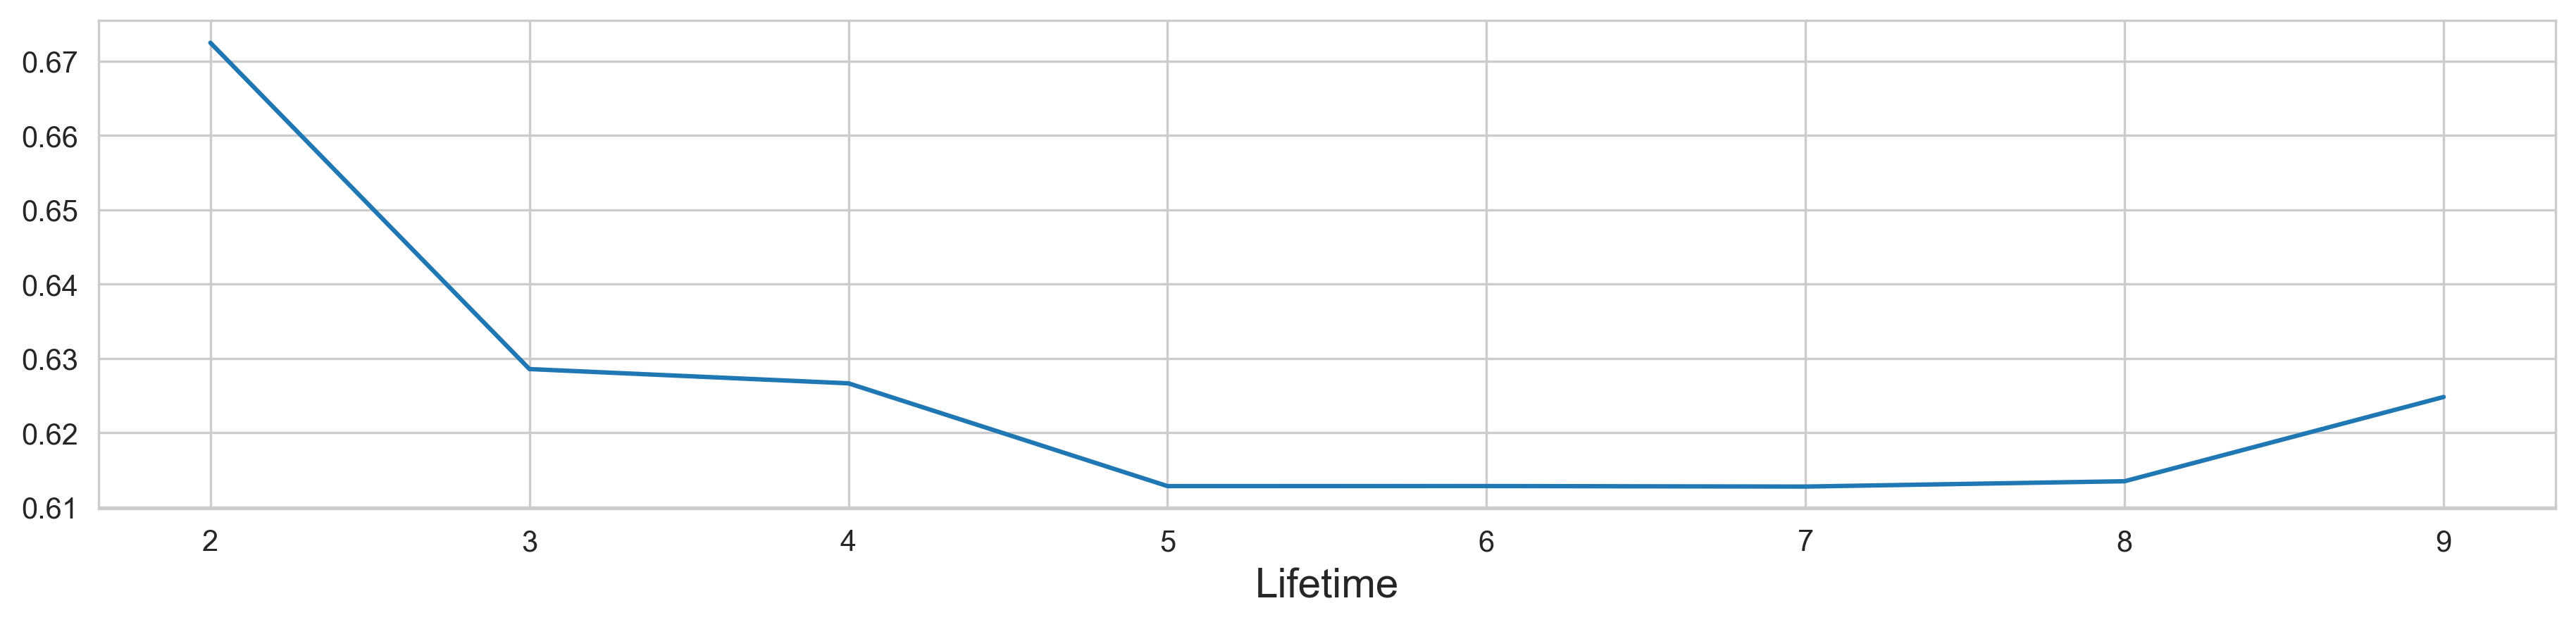

In [16]:
find_recency(df_training,'CustomerID','Date')

In [22]:
def Show_recency(data,CustomerID,Date,n_clusters):
    global df_lifetime
    
    df_lifetime = data.copy()
    df_lifetime['Lifetime'] = ((data['Date'].max() - data['Date']).dt.days)
    df_lifetime = df_lifetime.groupby(CustomerID).agg('max')
    
    df_recency = data.groupby('CustomerID')['Date'].apply(lambda x: ((x.max()-x.min()).days))
    df_recency = df_recency.reset_index()
    df_recency = df_recency.rename(columns={'Date':'Recency'})
    
    df_lifetime = df_lifetime.merge(df_recency,on='CustomerID',how='left')
            
    df_lifetime = df_lifetime.sort_values(by='Lifetime')
    
    Lifetime = df_lifetime[['Lifetime']]
    
    k_means = KMeans(n_clusters=n_clusters,max_iter=1000,random_state=42,n_init='auto').fit(Lifetime)
    df_lifetime['lifetime_cluster'] = k_means.labels_+1
    
    return df_lifetime

In [23]:
df_lifetime = Show_recency(df_training,'CustomerID','Date',2)
df_lifetime

,CustomerID,Date,InvoiceNo,UnitPrice,Quantity,Lifetime,Recency,lifetime_cluster
443,13436,2011-12-08,581233,16.95,25,1,0,2
1920,15520,2011-12-08,581241,4.95,120,1,0,2
343,13298,2011-12-08,581385,3.75,72,1,0,2
1241,14569,2011-12-08,581416,14.95,48,1,0,2
2269,16000,2011-12-07,581110,13.35,620,2,0,2
...,...,...,...,...,...,...,...,...
1322,14688,2011-12-02,580257,25.00,120,373,366,1
1328,14696,2011-12-05,580657,9.95,48,373,369,1
2605,16456,2011-09-01,565144,8.95,50,373,274,1
3689,17968,2010-12-01,536464,7.95,8,373,0,1


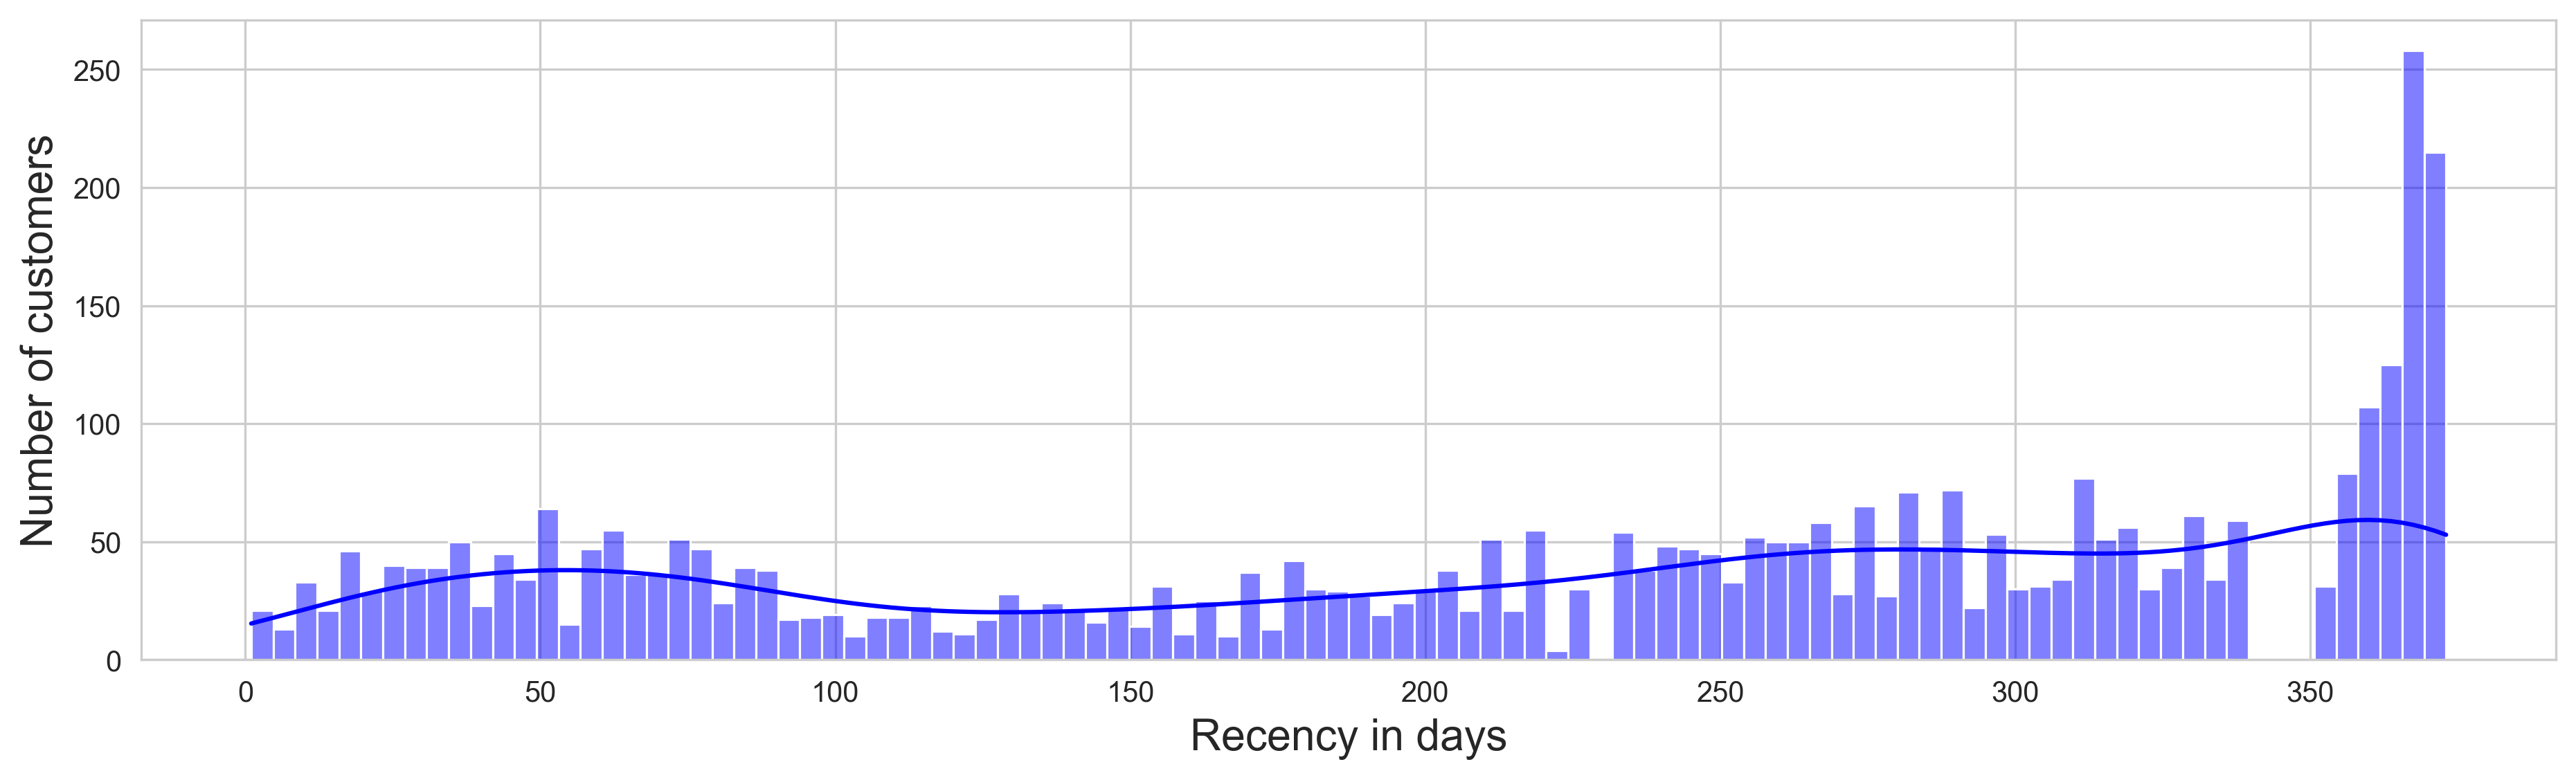

In [24]:
ax,fig = plt.subplots(figsize=(15,4),dpi=300)
ax = sns.histplot(x='Lifetime',kde=True,data=df_lifetime,color='blue',alpha=0.5,bins=100)
plt.xlabel('Recency in days',fontsize=15)
plt.ylabel('Number of customers',fontsize=15);

# Explore Frequency

In [25]:
def find_frequency(data,CustomerID,Date):

    df_frequency = data.groupby(CustomerID)['InvoiceNo'].nunique().reset_index()
    
    df_frequency = df_frequency.rename(columns={'InvoiceNo':'Frequency'})
    df_frequency = df_frequency[df_frequency['Frequency'] > 0]

    df_frequency = df_frequency.sort_values(by='Frequency',ascending=True)
    
    frequency = df_frequency[['Frequency']]
    
    clusters = []
    inertia_vals = []

    for k in range(1, 10, 1):
        model = KMeans(n_clusters=k, random_state=42,n_init='auto').fit(frequency)
        clusters.append(model)
        inertia_vals.append(model.inertia_)
    
    for i in range(1,9,1):
        print(silhouette_score(frequency, clusters[i].predict(frequency)))
        
    Kmeans_per_k = [KMeans(n_clusters=k,random_state=42,n_init='auto').fit(frequency) for k in range(1, 10)]
    silhouette_scores = [silhouette_score(frequency, model.labels_) for model in Kmeans_per_k[1:]]
  
    ax,fig = plt.subplots(figsize=(15,3),dpi=300)
    ax = sns.lineplot(x=range(2,10),y=silhouette_scores)
    plt.xlabel('Frequency',fontsize=14)
    
    c = df_frequency[df_frequency['CustomerID']==12747]
    print(c.head())
    
    return df_frequency

0.890620231618527
0.8298520679585326
0.6913504935532014
0.6944528481784402
0.6943591620977158
0.6757192411363955
0.675681295235189
0.6774635422785898
   CustomerID  Frequency
0       12747         11


,CustomerID,Frequency
1806,15361,1
1368,14752,1
1366,14747,1
3689,17968,1
3688,17967,1
...,...,...
1770,15311,91
1266,14606,93
190,13089,97
3592,17841,124


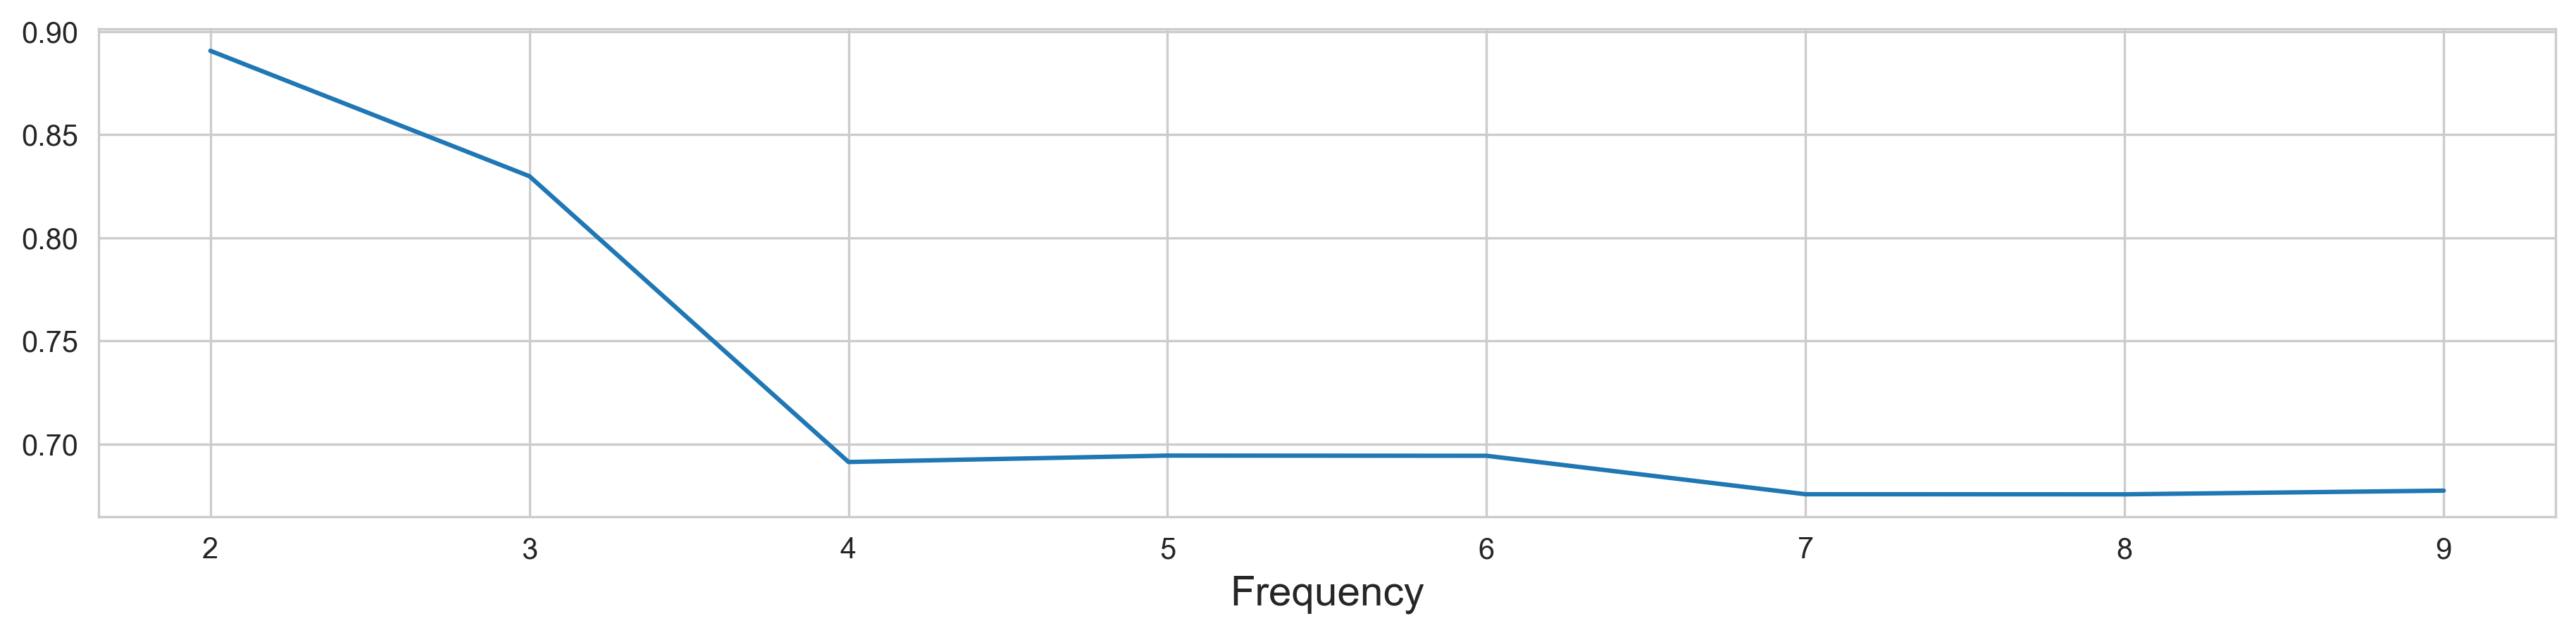

In [26]:
find_frequency(df_training,'CustomerID','Date')

In [30]:
def show_frequency(data,CustomerID,Date,n_clusters):
    global df_frequency
    
    df_frequency = data.groupby(CustomerID)['InvoiceNo'].nunique().reset_index()
    
    df_frequency = df_frequency.rename(columns={'InvoiceNo':'Frequency'})
    df_frequency = df_frequency[df_frequency['Frequency'] > 0]

    df_frequency = df_frequency.sort_values(by='Frequency',ascending=True)
    
    frequency = df_frequency[['Frequency']]
    k_means = KMeans(n_clusters=n_clusters,max_iter=1000,random_state=42,n_init='auto').fit(frequency)
    df_frequency['Frequency_cluster'] = k_means.labels_+1
    
    return df_frequency

In [31]:
df_frequency = show_frequency(df_training,'CustomerID','Date',2)
df_frequency

,CustomerID,Frequency,Frequency_cluster
1806,15361,1,1
1368,14752,1,1
1366,14747,1,1
3689,17968,1,1
3688,17967,1,1
...,...,...,...
1770,15311,91,2
1266,14606,93,2
190,13089,97,2
3592,17841,124,2


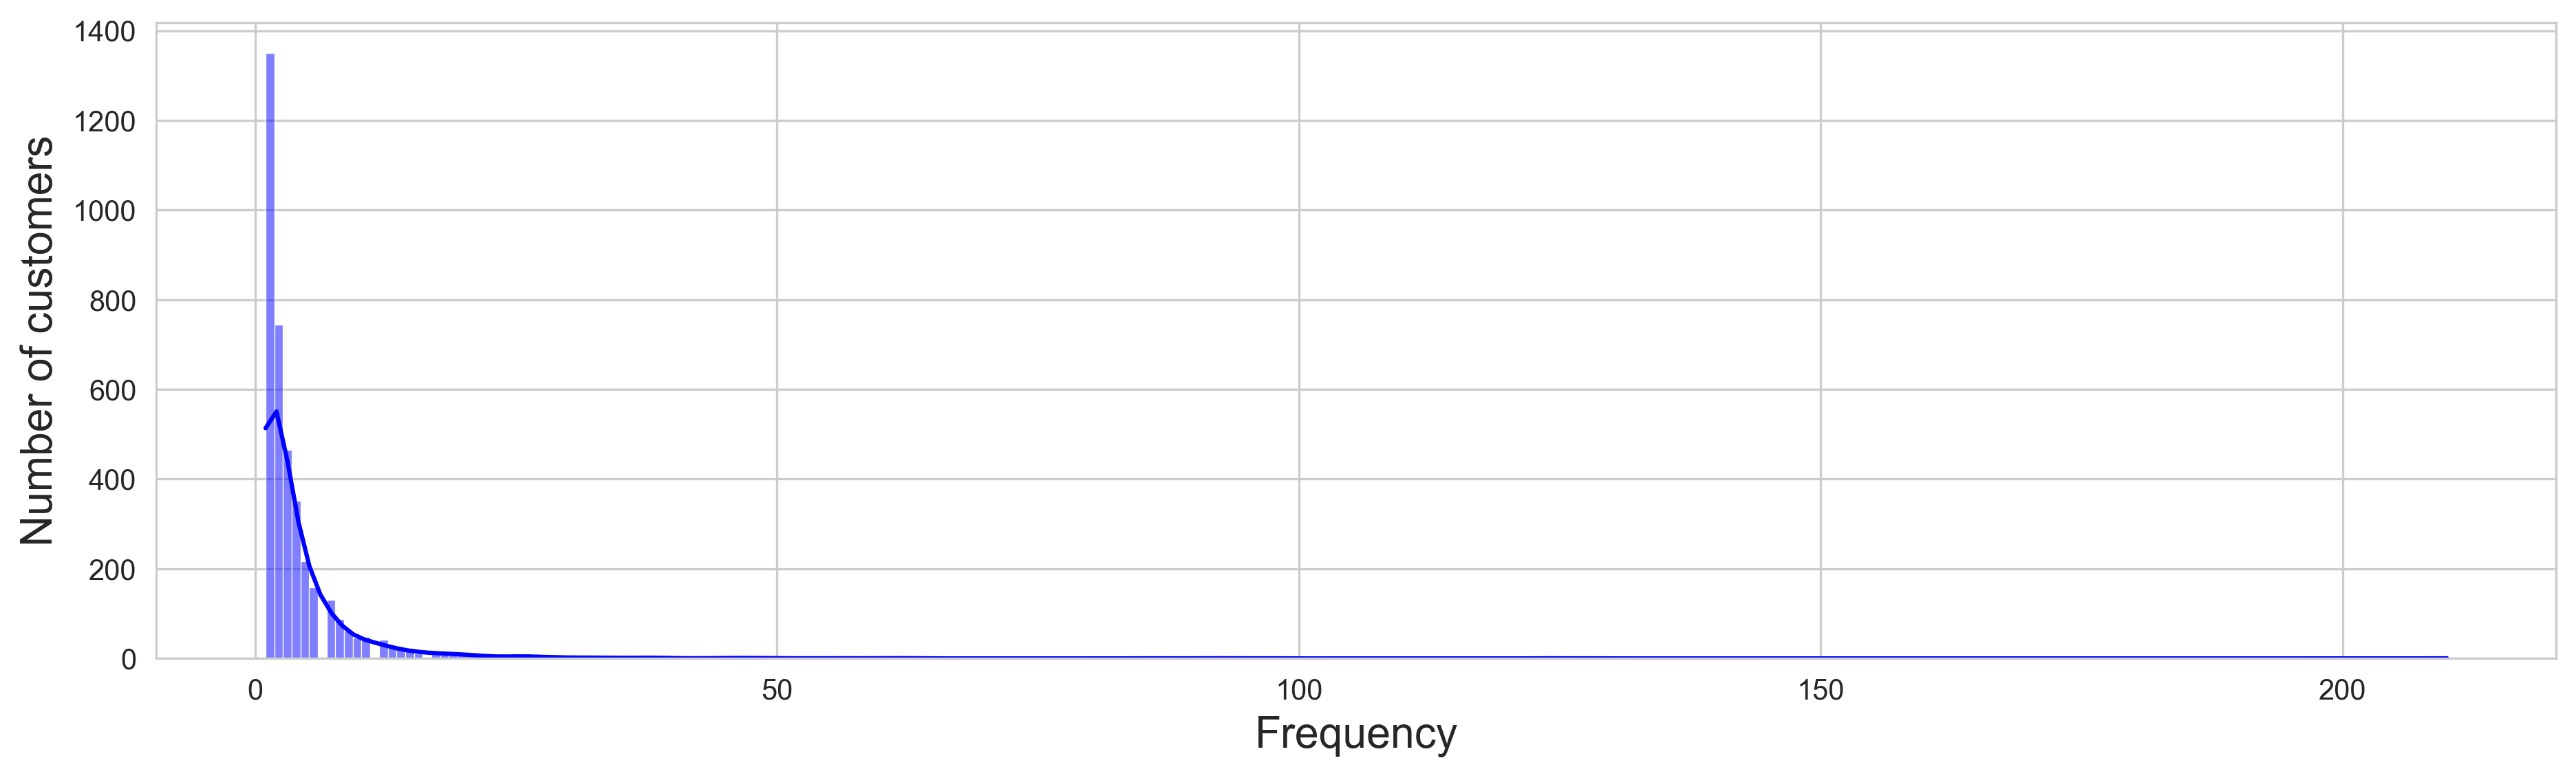

In [32]:
ax,fig = plt.subplots(figsize=(15,4),dpi=300)
ax = sns.histplot(x='Frequency',kde=True,data=df_frequency[df_frequency['Frequency'] < 500],color='blue',alpha=0.5,bins=250)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Number of customers',fontsize=15);

# Explore Monetary

In [33]:
def find_monetary(data,CustomerID,UnitPrice,Quantity):
    
    df_Revenue = data.copy()
    df_Revenue['Monetary'] = round(df_Revenue[UnitPrice] * df_Revenue[Quantity],2)
    df_value = df_Revenue.groupby(['Date','CustomerID'])['Monetary'].sum().reset_index()
    df_value = round(df_value.groupby('CustomerID')['Monetary'].mean(),2)
    
    df_features = data.copy()
    df_features = df_features.groupby(CustomerID).agg({'UnitPrice':'sum','Quantity':'sum'})
    df_features = df_features.rename(columns={'UnitPrice':'Price_sum','Quantity':'Quantity_sum'})
    
    df_monetary = df_features.merge(df_value,on='CustomerID',how='left').reset_index()
    df_monetary = df_monetary[df_monetary['Monetary'] > 0]
    df_monetary = df_monetary.sort_values(by='Monetary',ascending=False)
        
    monetary = df_monetary[['Monetary']]
    
    clusters = []
    inertia_vals = []

    for k in range(1, 10, 1):
        model = KMeans(n_clusters=k, random_state=42,n_init='auto').fit(monetary)
        clusters.append(model)
        inertia_vals.append(model.inertia_)
    
    for i in range(1,9,1):
        print(silhouette_score(monetary, clusters[i].predict(monetary)))
        
    Kmeans_per_k = [KMeans(n_clusters=k,random_state=42,n_init='auto').fit(monetary) for k in range(1, 10)]
    silhouette_scores = [silhouette_score(monetary, model.labels_) for model in Kmeans_per_k[1:]]
  
    ax,fig = plt.subplots(figsize=(15,3),dpi=300)
    ax = sns.lineplot(x=range(2,10),y=silhouette_scores)
    plt.xlabel('Monetary',fontsize=14)
    
    return df_monetary

0.9897314111278839
0.975755913913632
0.8109498854416605
0.6488095691804333
0.646814861427919
0.566289880851679
0.564507599069777
0.5817266191898325


,CustomerID,Price_sum,Quantity_sum,Monetary
1606,15098,1303.95,121,39916.50
2093,15749,30.44,18028,22267.15
2269,16000,30.11,5110,12393.70
3782,18102,1940.92,64124,9986.82
3313,17450,1143.32,69993,7205.58
...,...,...,...,...
3579,17816,23.98,30,9.14
1397,14792,6.20,2,6.20
2806,16738,1.25,3,3.75
2603,16454,3.95,3,3.45


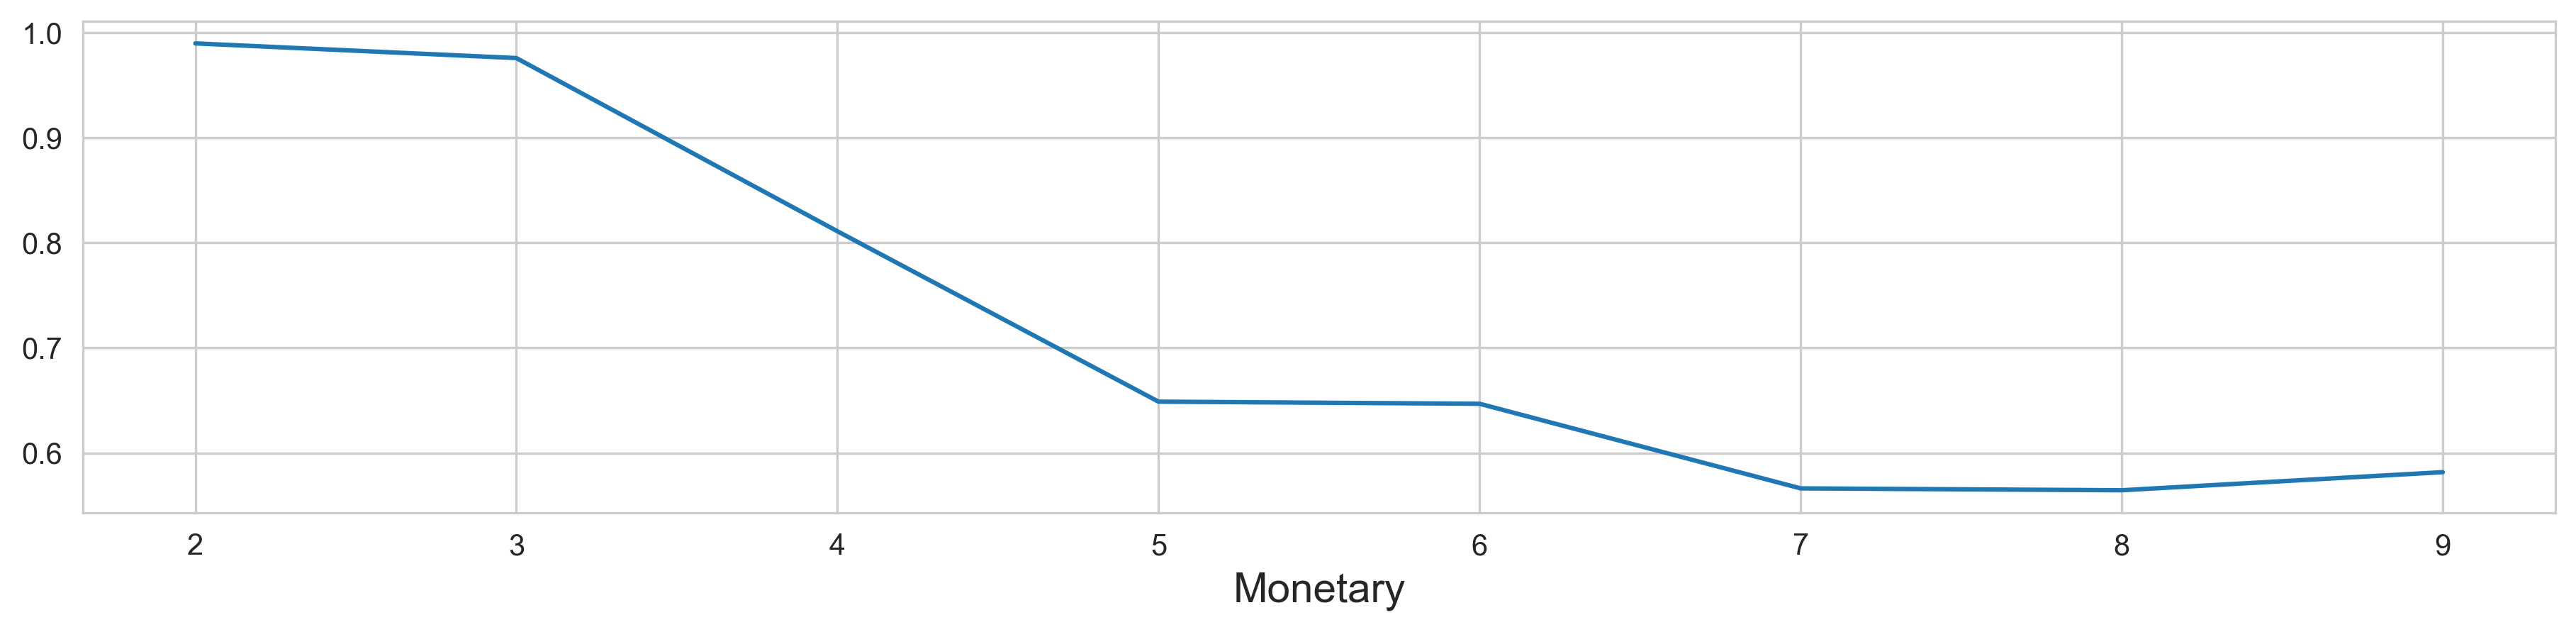

In [34]:
find_monetary(df_training,'CustomerID','UnitPrice','Quantity')

In [35]:
def show_monetary(data,CustomerID,UnitPrice,Quantity,n_clusters):
    global df_monetary
    
    df_Revenue = data.copy()
    df_Revenue['Monetary'] = round(df_Revenue[UnitPrice] * df_Revenue[Quantity],2)
    df_value = df_Revenue.groupby(['Date','CustomerID'])['Monetary'].sum().reset_index()
    df_value = round(df_value.groupby('CustomerID')['Monetary'].mean(),2)
    
    df_features = data.copy()
    df_features = df_features.groupby(CustomerID).agg({'UnitPrice':'sum','Quantity':'sum'})
    df_features = df_features.rename(columns={'UnitPrice':'Price_sum','Quantity':'Quantity_sum'})
    
    df_monetary = df_features.merge(df_value,on='CustomerID',how='left').reset_index()
    df_monetary = df_monetary[df_monetary['Monetary'] > 0]
    df_monetary = df_monetary.sort_values(by='Monetary',ascending=False)
    
    monetary = df_monetary[['Monetary']]
    k_means = KMeans(n_clusters=n_clusters,max_iter=1000,random_state=42,n_init='auto').fit(monetary)
    df_monetary['Monetary_cluster'] = k_means.labels_+1
    
    return df_monetary

In [36]:
df_monetary = show_monetary(df_training,'CustomerID','UnitPrice','Quantity',2)

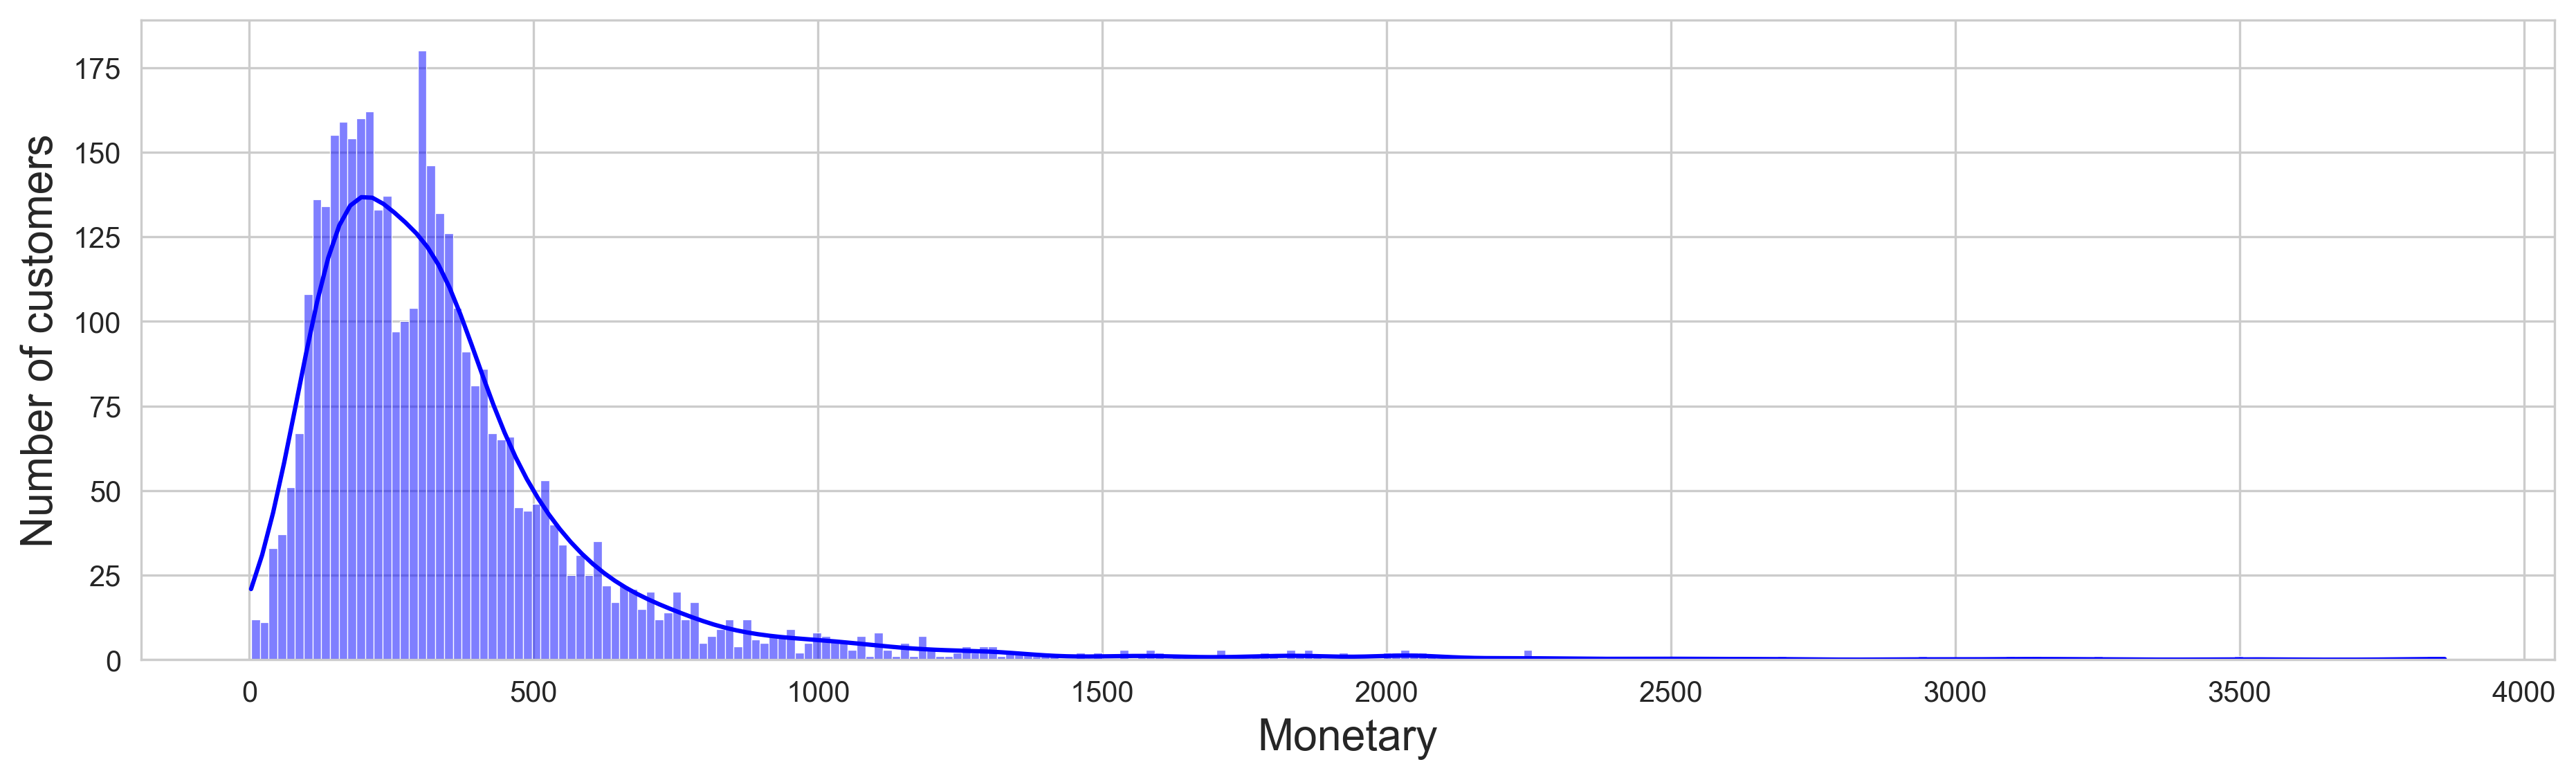

In [37]:
ax,fig = plt.subplots(figsize=(15,4),dpi=300)
ax = sns.histplot(x='Monetary',kde=True,data=df_monetary[df_monetary['Monetary'] < 4000],color='blue',alpha=0.5,bins=250)
plt.xlabel('Monetary',fontsize=15)
plt.ylabel('Number of customers',fontsize=15);

# Final DataFrame with RFM Score

In [38]:
def construct_final_df():
    global df_final
    
    df_final = df_lifetime.merge(df_frequency,on='CustomerID',how='left')
    df_final = df_final.merge(df_monetary,on='CustomerID',how='left')
    df_final['RFM_score'] = df_final['lifetime_cluster']+df_final['Frequency_cluster']+df_final['Monetary_cluster']
    df_final = df_final[(df_final['Frequency'] > 1) & (df_final['Monetary'] > 0)]
    df_final = df_final.sort_values(by='CustomerID').reset_index(drop=True)
    
    return df_final

In [39]:
construct_final_df()

,CustomerID,Date,InvoiceNo,UnitPrice,Quantity,Lifetime,Recency,lifetime_cluster,Frequency,Frequency_cluster,Price_sum,Quantity_sum,Monetary,Monetary_cluster,RFM_score
0,12747,2011-12-07,581163,15.95,48,369,367,1,11,1,449.89,1275,381.46,1,3
1,12748,2011-12-09,581580,850.50,576,373,373,1,210,2,12205.60,25748,295.79,1,4
2,12749,2011-12-06,580750,50.00,75,213,210,1,5,1,994.99,1471,1022.72,1,3
3,12820,2011-12-06,580973,4.95,48,326,323,1,4,1,112.38,722,235.58,1,3
4,12822,2011-09-30,569024,14.95,48,87,17,2,2,1,123.86,550,474.44,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,18272,2011-12-07,581126,8.25,48,246,244,1,6,1,380.91,2050,513.10,1,3
2565,18273,2011-12-07,581136,2.55,40,257,255,1,3,1,7.65,80,68.00,1,3
2566,18282,2011-12-02,580173,12.75,48,126,119,2,2,1,62.39,103,89.02,1,4
2567,18283,2011-12-06,580872,15.95,13,337,334,1,16,1,1220.93,1397,149.63,1,3


## Divide the customers into categories based on the RFM_score

### Check the distribution of RFM_score vs the Monetary_value

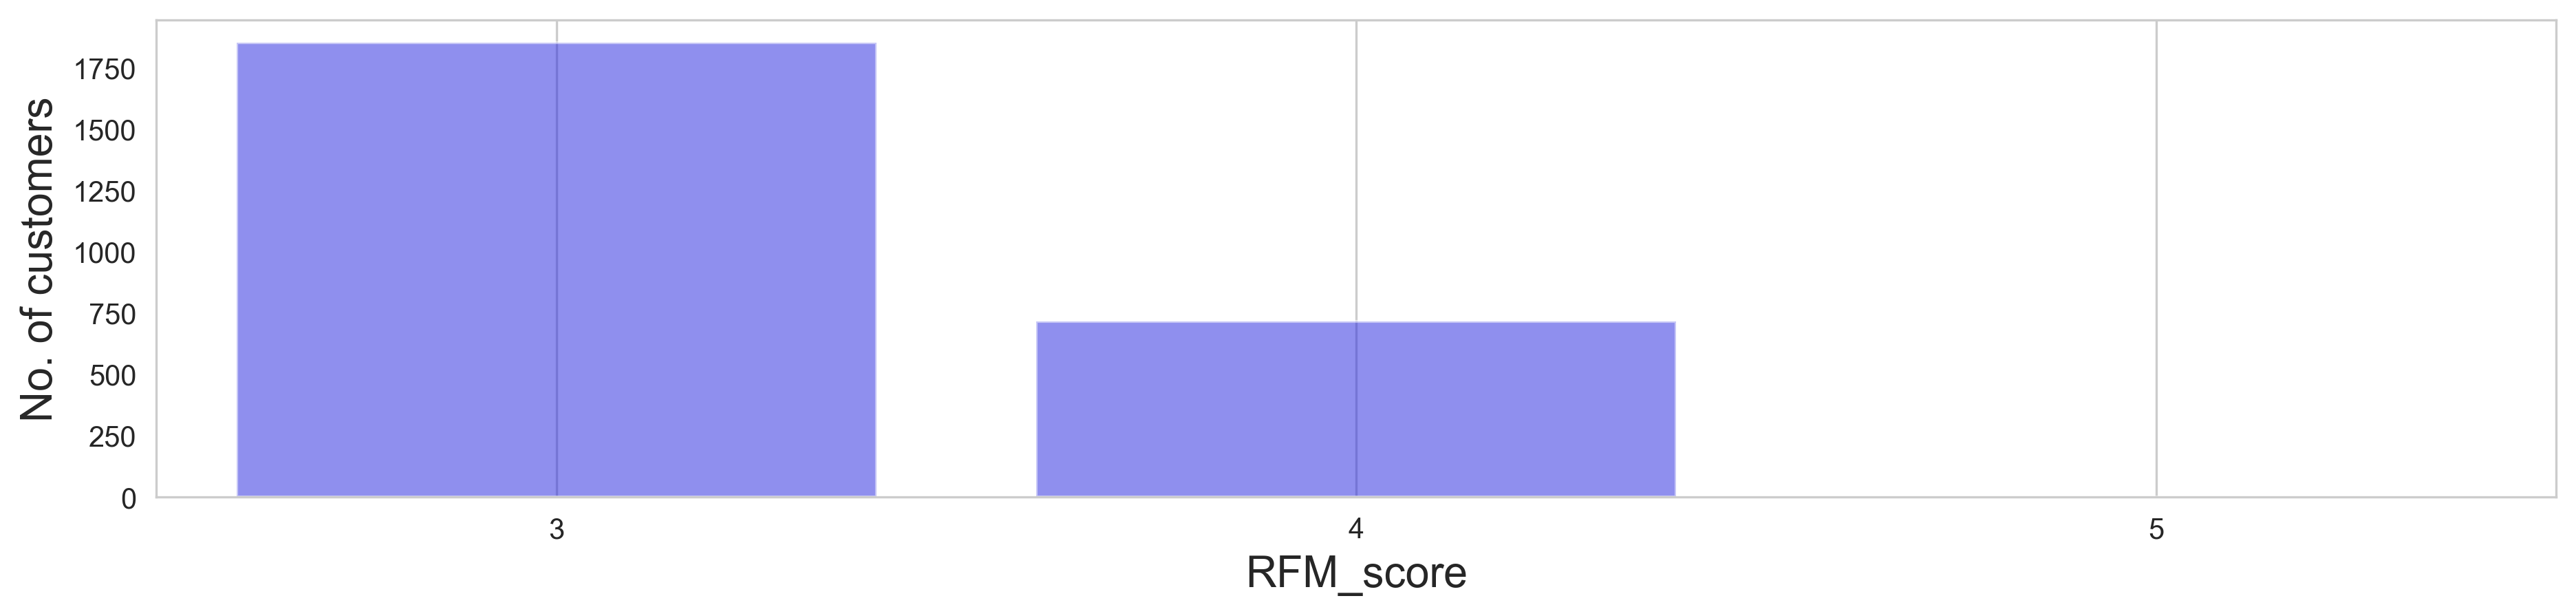

In [42]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.countplot(x='RFM_score',data=df_final,color='blue',alpha=0.5)
plt.xlabel('RFM_score',fontsize=15)
plt.ylabel('No. of customers',fontsize=15)
plt.grid();

In [43]:
df_final.groupby('RFM_score')['RFM_score'].sum()

RFM_score
3    5559
4    2860
5       5
Name: RFM_score, dtype: int32

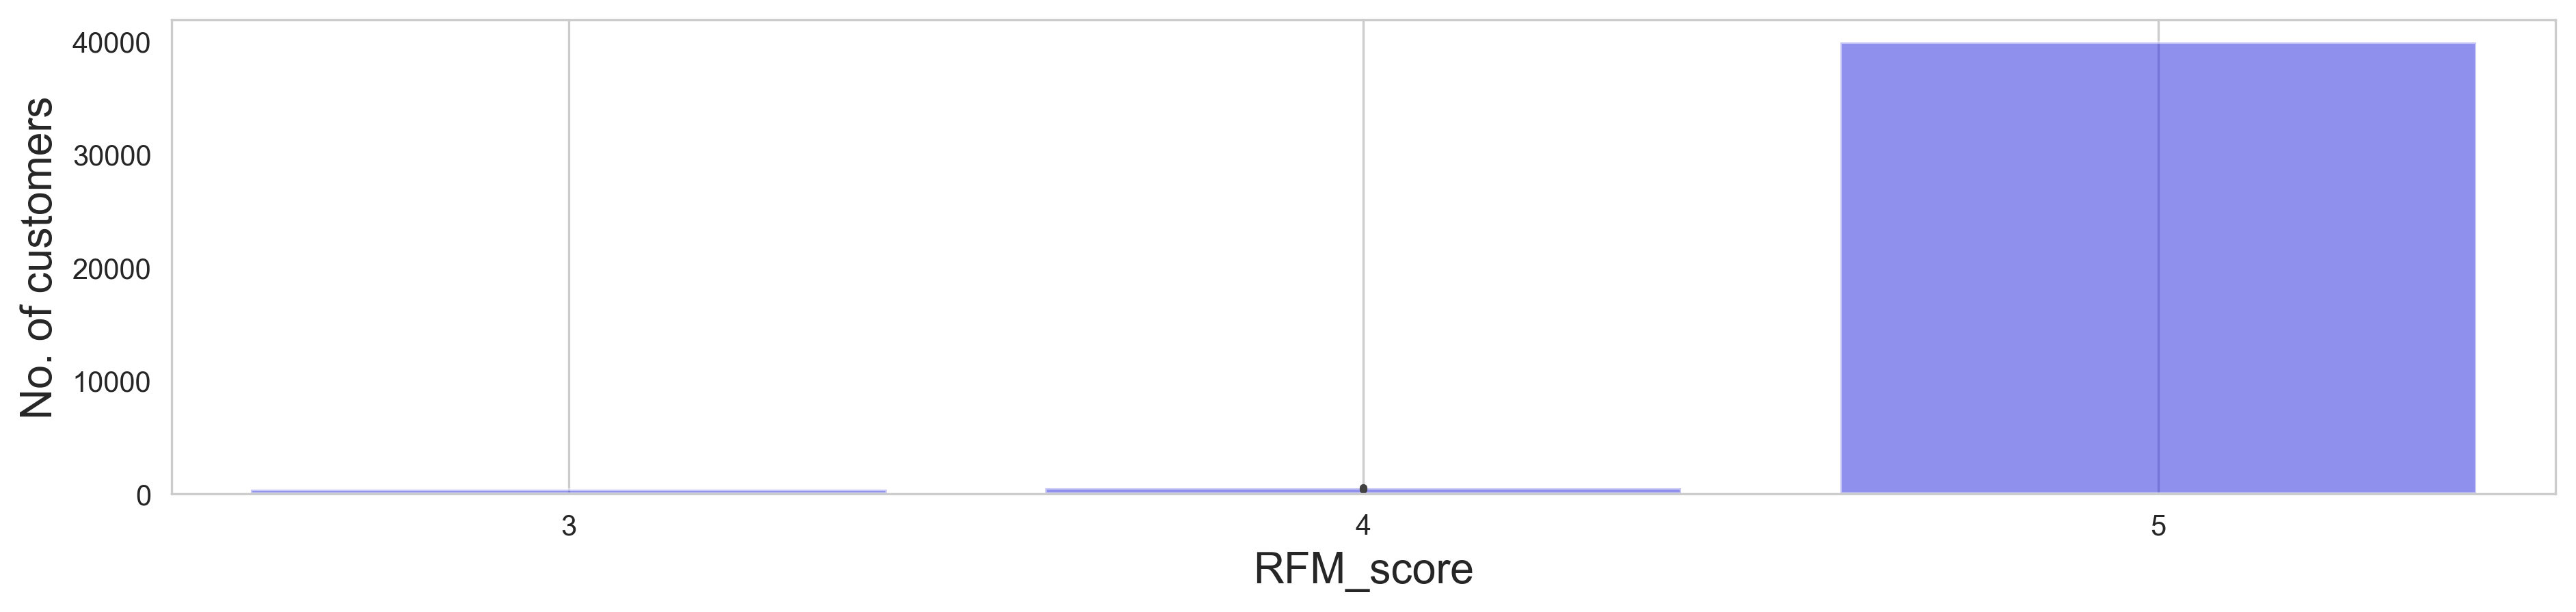

In [45]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.barplot(x='RFM_score',y='Monetary',data=df_final,color='blue',alpha=0.5)
plt.xlabel('RFM_score',fontsize=15)
plt.ylabel('No. of customers',fontsize=15)
plt.grid();

### Divide the data into 3 groups (low, mid & high)

In [46]:
def divide_groups():
    df_final.loc[(df_final['RFM_score'] <= 4),'clv_segment'] = 1
    df_final.loc[(df_final['RFM_score'] > 4) & (df_final['RFM_score'] < 6),'clv_segment'] = 2
    df_final.loc[(df_final['RFM_score'] >= 6),'clv_segment'] = 3

In [47]:
divide_groups()

### Analyze the correlation  matrix

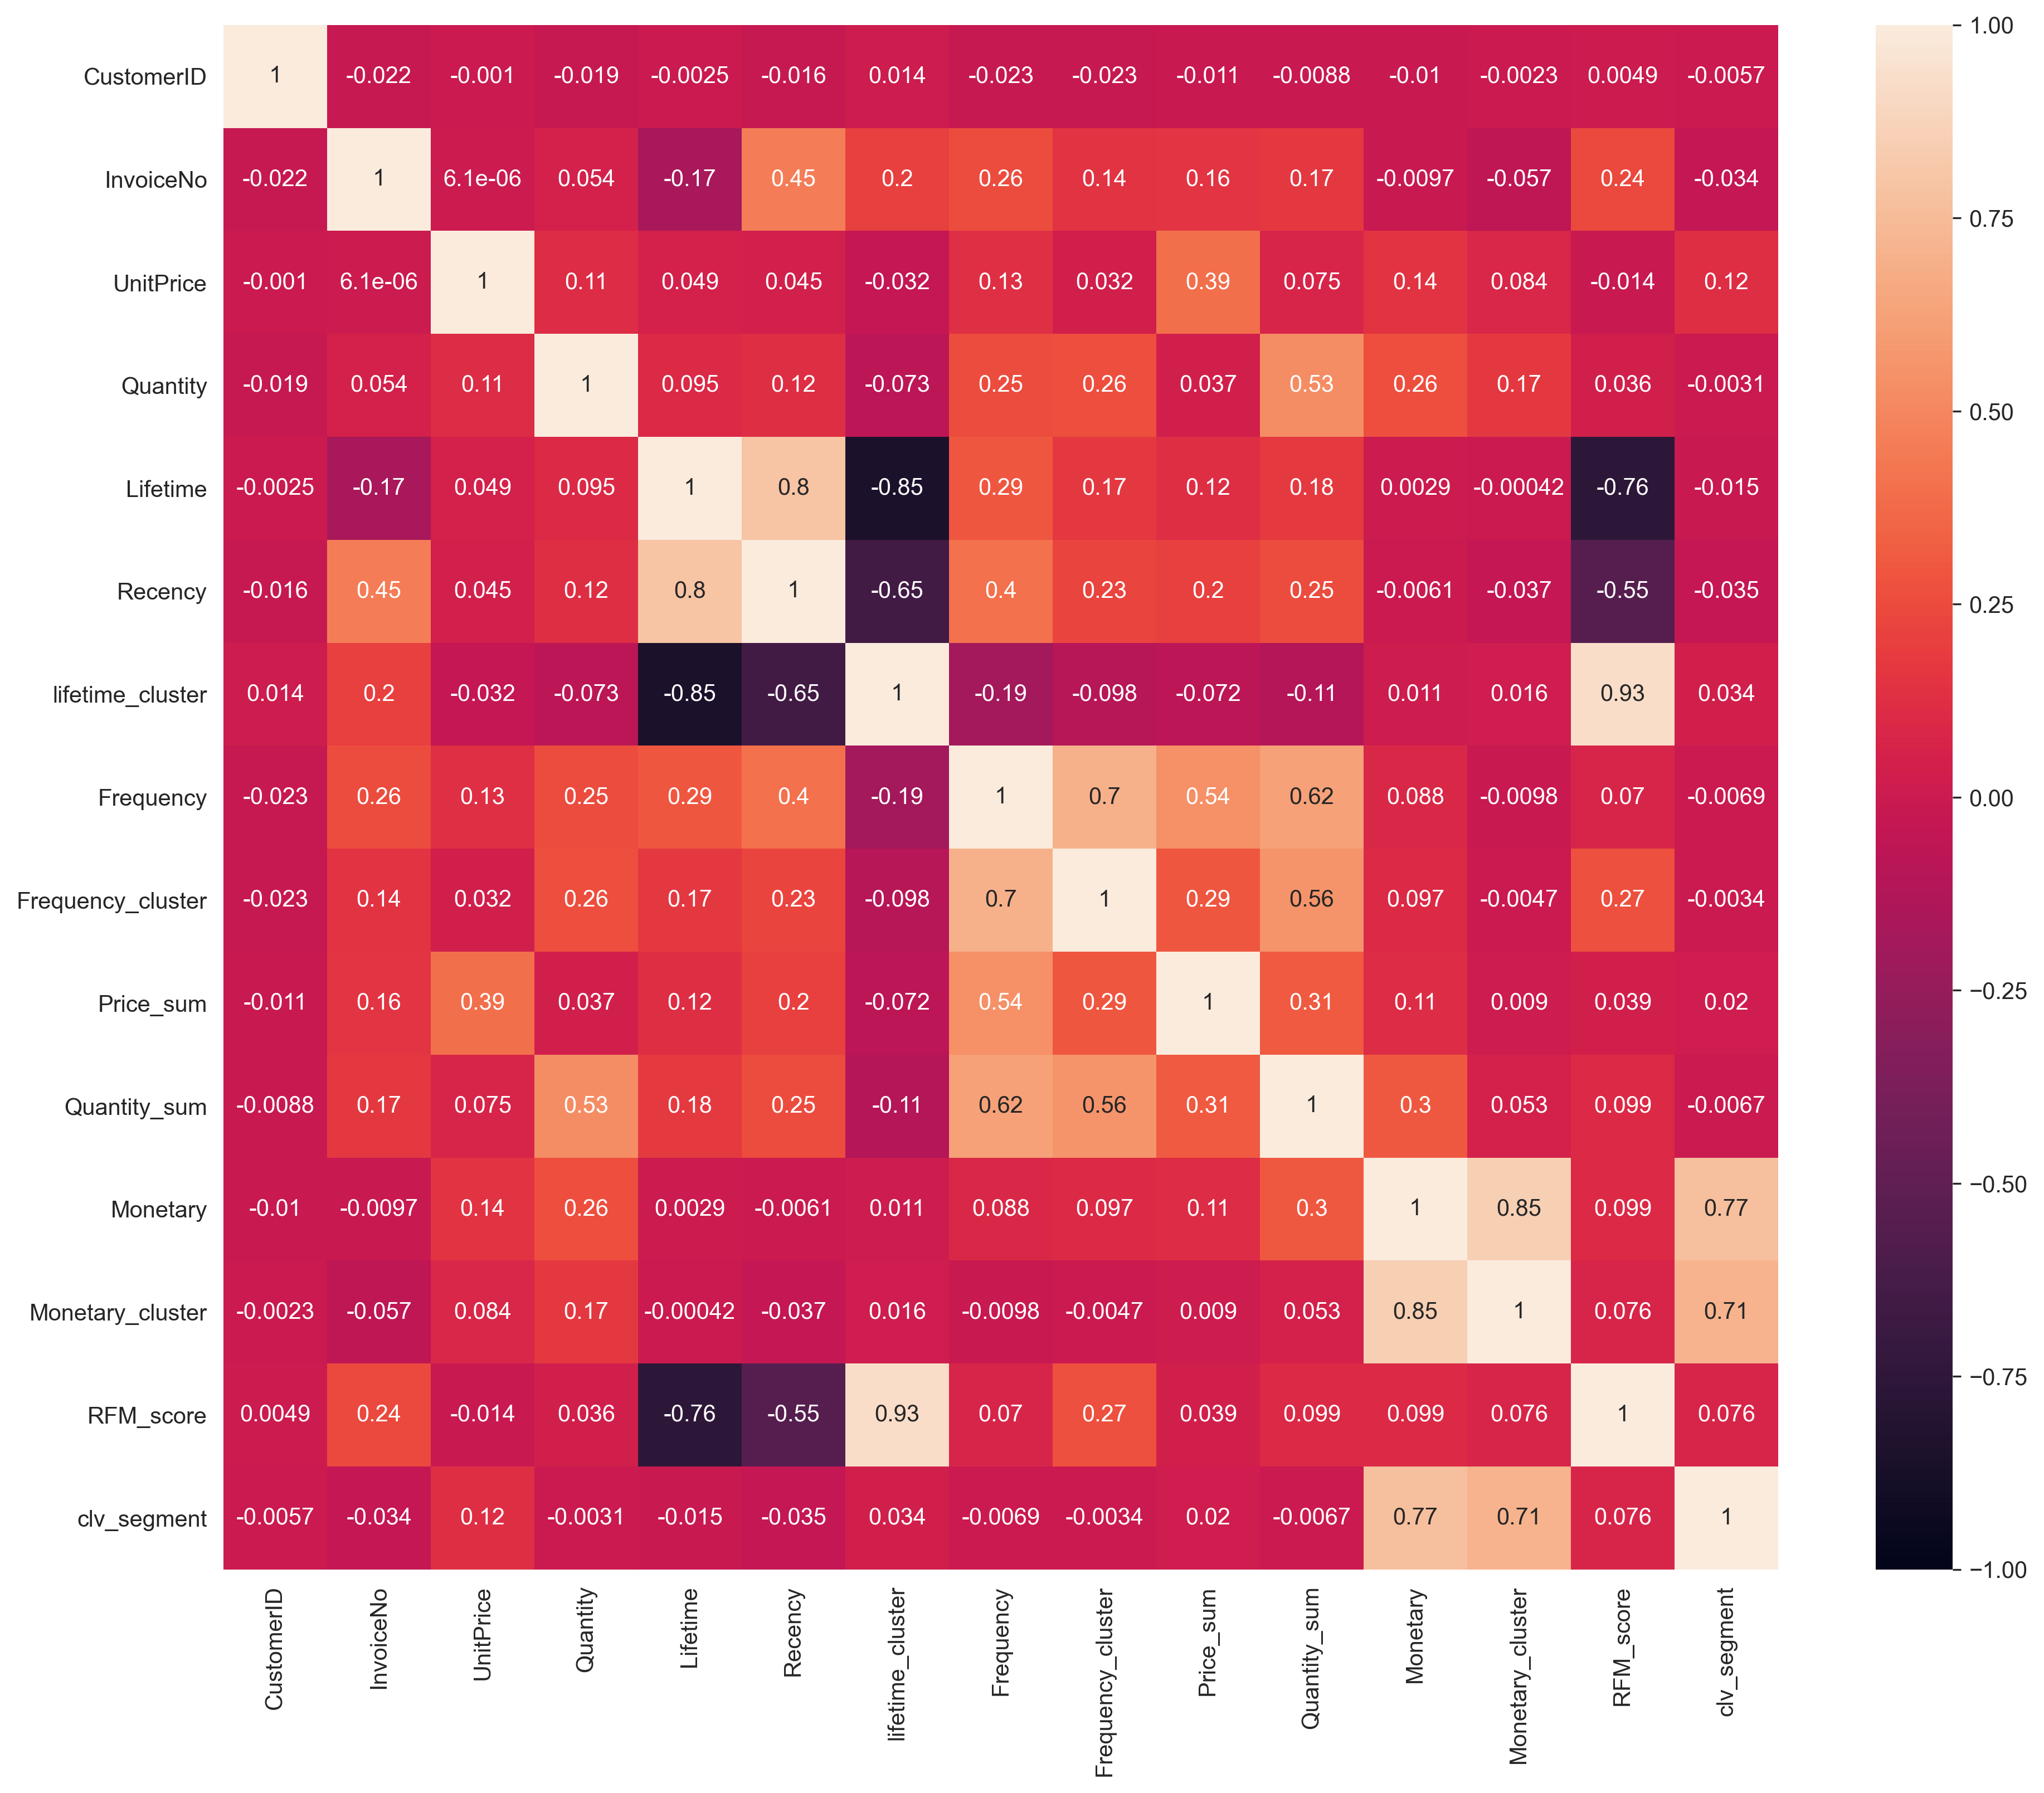

In [48]:
df_corr = df_final.corr()

ax,fig = plt.subplots(figsize=(15,12),dpi=300)
ax = sns.heatmap(df_corr,annot=True,cmap='rocket',vmin=-1,vmax=1)

### Split the Data into X & y for training and testing of the model and balance y

In [49]:
df_final.head()

,CustomerID,Date,InvoiceNo,UnitPrice,Quantity,Lifetime,Recency,lifetime_cluster,Frequency,Frequency_cluster,Price_sum,Quantity_sum,Monetary,Monetary_cluster,RFM_score,clv_segment
0,12747,2011-12-07,581163,15.95,48,369,367,1,11,1,449.89,1275,381.46,1,3,1.0
1,12748,2011-12-09,581580,850.50,576,373,373,1,210,2,12205.60,25748,295.79,1,4,1.0
2,12749,2011-12-06,580750,50.00,75,213,210,1,5,1,994.99,1471,1022.72,1,3,1.0
3,12820,2011-12-06,580973,4.95,48,326,323,1,4,1,112.38,722,235.58,1,3,1.0
4,12822,2011-09-30,569024,14.95,48,87,17,2,2,1,123.86,550,474.44,1,4,1.0


In [50]:
X = df_final.drop(['Date','Monetary'],axis=1)
y = df_final['Monetary']

In [51]:
X_features = X

In [52]:
X_features.head()
#X_features.isna().sum()

,CustomerID,InvoiceNo,UnitPrice,Quantity,Lifetime,Recency,lifetime_cluster,Frequency,Frequency_cluster,Price_sum,Quantity_sum,Monetary_cluster,RFM_score,clv_segment
0,12747,581163,15.95,48,369,367,1,11,1,449.89,1275,1,3,1.0
1,12748,581580,850.50,576,373,373,1,210,2,12205.60,25748,1,4,1.0
2,12749,580750,50.00,75,213,210,1,5,1,994.99,1471,1,3,1.0
3,12820,580973,4.95,48,326,323,1,4,1,112.38,722,1,3,1.0
4,12822,569024,14.95,48,87,17,2,2,1,123.86,550,1,4,1.0


## Split and transform the data

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,X_val,y_train,y_val = train_test_split(X_features,y,test_size=0.2,random_state=42,shuffle=True)

X_train_original = X_train.copy()

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')


X_train shape: (2055, 14)
X_val shape: (514, 14)


# Build a dataframe to check the best possible model

## Base model / Linear Regression

In [54]:
# Explainability graphs
#!pip install shap
import shap

In [120]:
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error

In [126]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

model_base = Lasso(fit_intercept=True,alpha=4.6,max_iter=3000)
model_base.fit(X_train,y_train)
y_pred = model_base.predict(X_val)

print('-'*80)
print(f'Base Model training Score Regression: {model_base.score(X_train,y_train)}')
print(f'Base Model testing Score Regression: {model_base.score(X_val,y_val)}')
print(f'Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_val,y_pred),2)}%')
print(f'root mean squared Error: {round(np.sqrt(mean_squared_error(y_val,y_pred)),2)}%')
print('-'*80)


--------------------------------------------------------------------------------
Base Model training Score Regression: 0.7996278795418015
Base Model testing Score Regression: 0.7746259543315814
Mean Absolute Percentage Error: 0.62%
Mean root squared Error: 477.96%
--------------------------------------------------------------------------------


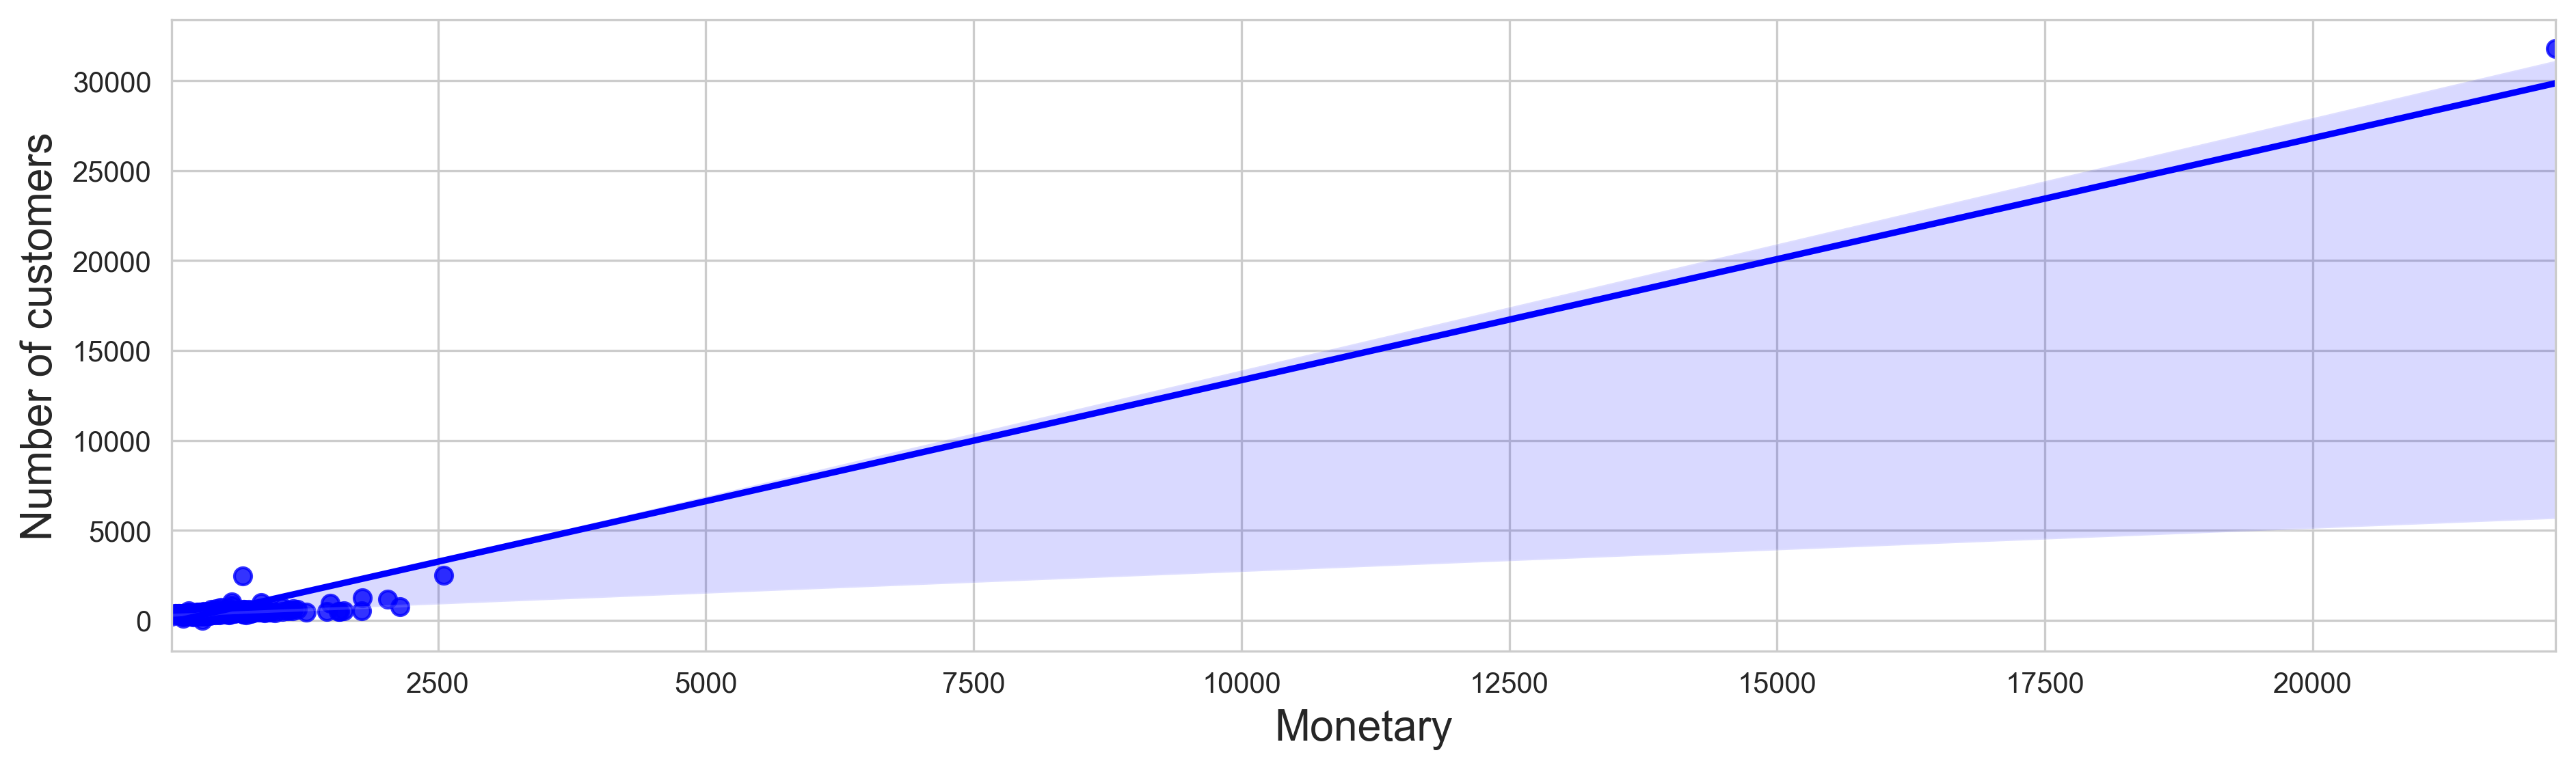

In [127]:
ax,fig = plt.subplots(figsize=(15,4),dpi=300)
ax = sns.regplot(x=y_val,y=y_pred,color='blue')
plt.xlabel('Monetary',fontsize=15)
plt.ylabel('Number of customers',fontsize=15);

In [128]:
eval_model = pd.DataFrame(data={'baseline':np.zeros(3),'Gredient_boost':np.zeros(3),
                                'Random_forest':np.zeros(3),'AdaBoost':np.zeros(3)})

mse_base = np.mean(np.square(y_val - y_pred))
eval_model.loc[0,'baseline'] = round(mse_base,0)
eval_model.loc[1,'baseline'] = round(mse_base/mse_base,2)
eval_model.loc[2,'baseline'] = round(model_base.score(X_val,y_val)*100,2)

s = round(model_base.score(X_val,y_val)*100,2)
eval_model.loc[2,'baseline'] = str(s)+'%'

eval_model


,baseline,Gredient_boost,Random_forest,AdaBoost
0,228448.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,77.46%,0.0,0.0,0.0


### Define a grid search function for estimating the best parameters

In [129]:
from sklearn.model_selection import GridSearchCV

def Grid_search_model(model,param_grid):
    global best_params
    model_cv = GridSearchCV(estimator = model,param_grid = param_grid,cv = 5,
                     scoring = 'neg_mean_squared_error',n_jobs = -1)
    model_cv = model_cv.fit(X_train, y_train)
    best_params = model_cv.best_params_
    return best_params

## Gredient Boost Regressor Model

In [130]:
from sklearn.ensemble import GradientBoostingRegressor

# GBR_param_grid = {'learning_rate':[0.06,0.07,0.08],
#                   'n_estimators':[700,750,800],
#                   'max_depth':[5,6,7,8],
#                   'max_leaf_nodes':[3,4,5]}

# Grid_search_model(GradientBoostingRegressor(),GBR_param_grid)


In [131]:
GBR_base = GradientBoostingRegressor(learning_rate=0.01,max_depth=3,max_leaf_nodes=5,n_estimators=3000,
                                     verbose=0,random_state=42)
GBR_base.fit(X_train,y_train)
GBR_y_pred = GBR_base.predict(X_val)

print('-'*80)
print(f'Gredient Boost Model training Score Regression: {GBR_base.score(X_train,y_train)}')
print(f'Gredient Boost testing Score Regression: {GBR_base.score(X_val,y_val)}')
print(f'Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_val,GBR_y_pred),2)}%')
print(f'root mean squared Error: {round(np.sqrt(mean_squared_error(y_val,GBR_y_pred)),2)}%')
print('-'*80)

--------------------------------------------------------------------------------
Gredient Boost Model training Score Regression: 0.9882933064293108
Gredient Boost testing Score Regression: 0.9013793830648801
Mean Absolute Percentage Error: 0.31%
Mean root square Error: 316.17%
--------------------------------------------------------------------------------


In [132]:
mse_GBR = np.mean(np.square(y_val - GBR_y_pred))
eval_model.loc[0,'Gredient_boost'] = round(mse_GBR,0)
eval_model.loc[1,'Gredient_boost'] = round(mse_GBR/mse_base,2)
score_GBR = round(GBR_base.score(X_val,y_val)*100,2)
eval_model.loc[2,'Gredient_boost'] = str(score_GBR)+'%'

eval_model

,baseline,Gredient_boost,Random_forest,AdaBoost
0,228448.0,99966.0,0.0,0.0
1,1.0,0.44,0.0,0.0
2,77.46%,90.14%,0.0,0.0


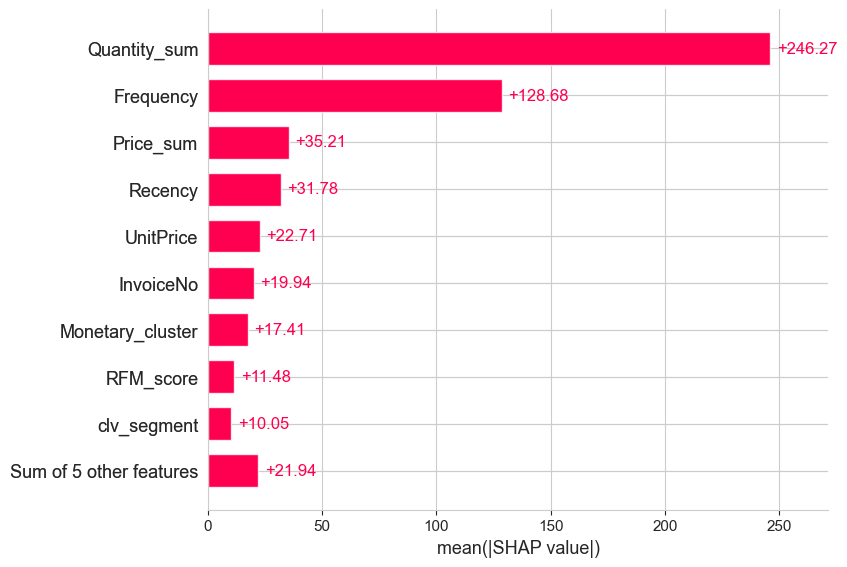

In [133]:
explainer = shap.Explainer(GBR_base)
shap_values = explainer(X_features)
shap.plots.bar(shap_values)

## Random Forest Model

In [134]:
from sklearn.ensemble import RandomForestRegressor

# RF_param_grid = {'n_estimators':[500,1000,1500],
#                  'max_features':[4,6,7,8],
#                   'max_depth':[5,6,7,8,10],
#                    'max_leaf_nodes':[10,12,14,16,18]}

# Grid_search_model(RandomForestRegressor(),RF_param_grid)


In [135]:
RF_base = RandomForestRegressor(n_estimators=2000,max_features=6,max_depth=4,max_leaf_nodes=6,random_state=42)
RF_base.fit(X_train,y_train)
RF_y_pred = RF_base.predict(X_val)

print('-'*80)
print(f'Random Forest training Score Regression: {RF_base.score(X_train,y_train)}')
print(f'Random Forest testing Score Regression: {RF_base.score(X_val,y_val)}')
print(f'Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_val,RF_y_pred),2)}%')
print(f'Mean root mean squared Error: {round(np.sqrt(mean_squared_error(y_val,RF_y_pred)),2)}%')
print('-'*80)


--------------------------------------------------------------------------------
Random Forest training Score Regression: 0.8026207760634424
Random Forest testing Score Regression: 0.6081016259327201
Mean Absolute Percentage Error: 0.66%
Mean root mean squared Error: 630.27%
--------------------------------------------------------------------------------


In [136]:
mse_RF = np.mean(np.square(y_val - RF_y_pred))
eval_model.loc[0,'Random_forest'] = round(mse_RF,0)
eval_model.loc[1,'Random_forest'] = round(mse_RF/mse_base,2)
score_RF = round(RF_base.score(X_val,y_val)*100,2)
eval_model.loc[2,'Random_forest'] = str(score_RF)+'%'

eval_model

,baseline,Gredient_boost,Random_forest,AdaBoost
0,228448.0,99966.0,397243.0,0.0
1,1.0,0.44,1.74,0.0
2,77.46%,90.14%,60.81%,0.0


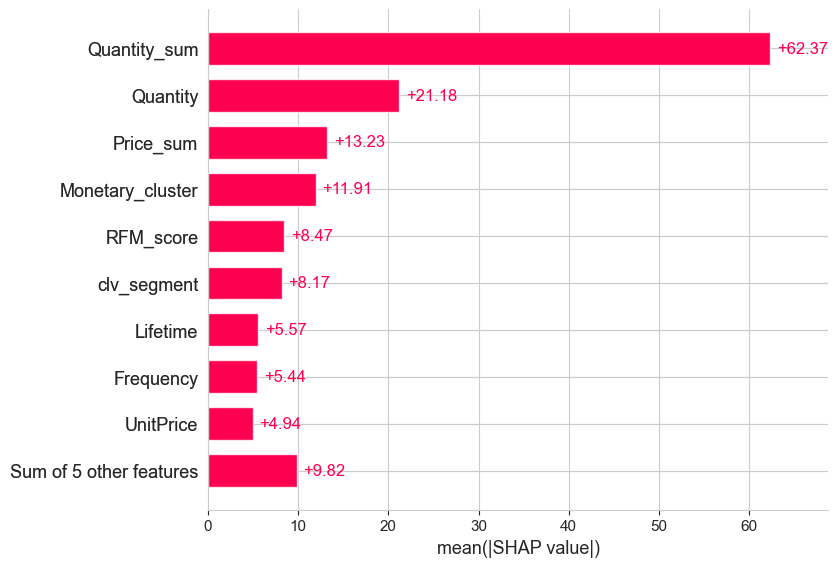

In [137]:
explainer = shap.Explainer(RF_base)
shap_values = explainer(X_features)
shap.plots.bar(shap_values)

## AdaBoost Model

In [138]:
from sklearn.ensemble import AdaBoostRegressor

# Ada_param_grid = {'n_estimators':[500,750,1000,1250,1500,2000,2500],
#                  'learning_rate':[0.25,0.3,0.35,0.4],
#                   'loss':['linear','square']}

# Grid_search_model(AdaBoostRegressor(),Ada_param_grid)


In [139]:
Ada_base = AdaBoostRegressor(n_estimators=1500,learning_rate=0.01,loss='linear',random_state=42)
Ada_base.fit(X_train,y_train)
Ada_y_pred = Ada_base.predict(X_val)

print('-'*80)
print(f'Random Forest training Score Regression: {Ada_base.score(X_train,y_train)}')
print(f'Random Forest testing Score Regression: {Ada_base.score(X_val,y_val)}')
print(f'Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_val,Ada_y_pred),2)}%')
print(f'root mean squared Error: {round(np.sqrt(mean_squared_error(y_val,Ada_y_pred)),2)}%')
print('-'*80)

--------------------------------------------------------------------------------
Random Forest training Score Regression: 0.8706103950093846
Random Forest testing Score Regression: 0.15188163622325523
Mean Absolute Percentage Error: 0.92%
root mean squared Error: 927.19%
--------------------------------------------------------------------------------


In [140]:
mse_Ada = np.mean(np.square(y_val - Ada_y_pred))
eval_model.loc[0,'AdaBoost'] = round(mse_Ada,0)
eval_model.loc[1,'AdaBoost'] = round(mse_Ada/mse_base,2)
score_Ada = round(Ada_base.score(X_val,y_val)*100,2)
eval_model.loc[2,'AdaBoost'] = str(score_Ada)+'%'

eval_model

,baseline,Gredient_boost,Random_forest,AdaBoost
0,228448.0,99966.0,397243.0,859685.0
1,1.0,0.44,1.74,3.76
2,77.46%,90.14%,60.81%,15.19%


## Deep Learning Model

In [141]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_tf = scaler.fit_transform(X_train)
X_val_tf = scaler.fit_transform(X_val)

In [112]:
import tensorflow as tf

tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Dense(512,activation='relu',input_dim=len(X_features.columns),kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.Dense(512,activation='relu'))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.Dense(512,activation='relu'))
tf_model.add(tf.keras.layers.Dropout(0.2))

tf_model.add(tf.keras.layers.Dense(1))

tf_model.compile(tf.keras.optimizers.Adam(0.001),loss='mae',metrics=['mse'])

print(f'Input shape: {tf_model.input_shape}')
tf_model.summary()

Input shape: (None, 14)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               7680      
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (

In [113]:
callbacks_list = tf.keras.callbacks.EarlyStopping(monitor="mse",patience=5)
history = tf_model.fit(X_train_tf,y_train,epochs=150,callbacks=[callbacks_list],validation_split=0.2)

Epoch 1/150
52/52 [==============================] - 1s 4ms/step - loss: 312.1101 - mse: 1233008.0000 - val_loss: 204.6656 - val_mse: 450691.6250
Epoch 2/150
52/52 [==============================] - 0s 3ms/step - loss: 231.7113 - mse: 1168536.2500 - val_loss: 202.4306 - val_mse: 452218.4375
Epoch 3/150
52/52 [==============================] - 0s 4ms/step - loss: 228.7424 - mse: 1165013.1250 - val_loss: 201.9210 - val_mse: 452772.1250
Epoch 4/150
52/52 [==============================] - 0s 5ms/step - loss: 225.6959 - mse: 1146794.2500 - val_loss: 199.9914 - val_mse: 443130.1875
Epoch 5/150
52/52 [==============================] - 0s 5ms/step - loss: 223.1190 - mse: 1135927.7500 - val_loss: 197.6172 - val_mse: 443761.4062
Epoch 6/150
52/52 [==============================] - 0s 5ms/step - loss: 219.1086 - mse: 1118608.3750 - val_loss: 195.5119 - val_mse: 431041.8750
Epoch 7/150
52/52 [==============================] - 0s 4ms/step - loss: 214.7863 - mse: 1101937.6250 - val_loss: 199.1530 -

In [114]:
tf_model.evaluate(X_train_tf,y_train)

65/65 [==============================] - 0s 841us/step - loss: 134.0416 - mse: 139242.0000


[134.04161071777344, 139242.0]

In [115]:
tf_model.evaluate(X_val_tf,y_val)

17/17 [==============================] - 0s 861us/step - loss: 218.9605 - mse: 84800.6641


[218.96046447753906, 84800.6640625]

In [142]:
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error

tf_pred = tf_model.predict(X_val_tf).ravel()
r2 = r2_score(y_val,tf_pred)
rmse = np.round(np.sqrt(mean_squared_error(y_val,tf_pred)),2)

print(f'R2_score: {r2}')
print(f'rmse: {rmse}')

17/17 [==============================] - 0s 910us/step
R2_score: 0.9163402558524755
rmse: 291.21


In [118]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

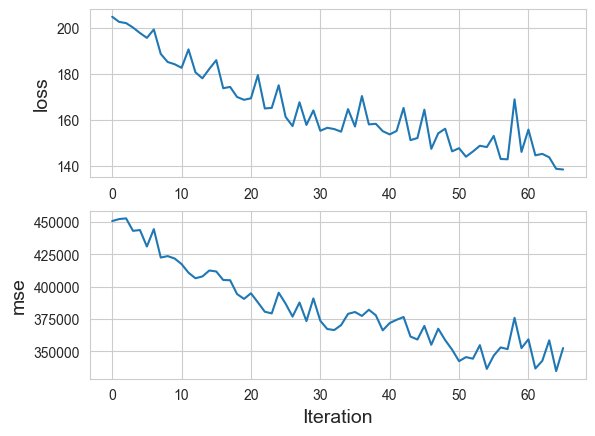

In [119]:
history_dict = history.history
history_dict.keys() # to get the loss names
loss_values = history_dict['val_loss']
acc_values = history_dict['val_mse']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2)
axes[0].set_ylabel("loss", fontsize=14)
axes[0].plot(loss_values)
axes[1].set_ylabel("mse", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(acc_values)
plt.show()

## Choose the best model

In [147]:
model_final = GBR_base

### Predict the X_val

In [148]:
y_pred = model_final.predict(X_val)

In [149]:
print('-'*80)
print(f'Final model Score Regression: {model_final.score(X_train,y_train)}')
print(f'Final model testing Score Regression: {model_final.score(X_val,y_val)}')
print(f'Final model Percentage Error: {round(mean_absolute_percentage_error(y_val,y_pred),2)}%')
print('-'*80)

--------------------------------------------------------------------------------
Final model Score Regression: 0.9882933064293108
Final model testing Score Regression: 0.9013793830648801
Final model Percentage Error: 0.31%
--------------------------------------------------------------------------------


### Predict the new Data

In [150]:
# X_standard = scaler.transform(X_features) # Should be df_testing with new data
y_pred = model_final.predict(X_features)

In [151]:
y_pred = pd.DataFrame(y_pred,columns=['Predicted_total'])
y_temp = y_pred.join(X_train_original) # Should be df_testing with new data
y_temp['CustomerID'] = X['CustomerID']
y_pred = y_temp.loc[:,['Predicted_total','CustomerID']]

y_pred

,Predicted_total,CustomerID
0,337.119494,12747
1,326.685147,12748
2,844.286588,12749
3,276.209538,12820
4,486.632869,12822
...,...,...
2564,448.684863,18272
2565,81.547958,18273
2566,128.216932,18282
2567,226.335016,18283


In [152]:
y_pred.isna().sum()

Predicted_total    0
CustomerID         0
dtype: int64

# Get the final dataframe according to the best model

In [153]:
def get_final_dataframe(n):
    df_cltv = df_final.copy()
    global df_predicted

    df_predicted = y_pred.merge(df_final,on='CustomerID',how='inner')
    df_predicted = df_predicted[['CustomerID']+list(df_predicted.iloc[:,2:])+['Predicted_total']]
    df_predicted = df_predicted.drop(['lifetime_cluster','Frequency_cluster','Monetary_cluster'],axis=1)

    df_predicted['Uplift%'] = round((df_predicted['Predicted_total'] - df_predicted['Monetary'])/100,2)
    df_predicted['Uplift%'] = round(df_predicted['Uplift%'],1)

    df_predicted = df_predicted.drop('Date',axis=1)
    df_predicted = df_predicted.rename(columns={'Predicted_total':'Predicted_clv'})
    df_predicted['Predicted_clv'] = round(df_predicted['Predicted_clv'],1)

    k_means_cltv = KMeans(n_clusters=3,max_iter=1000,random_state=42)
    k_means_cltv.fit(df_predicted[['Predicted_clv']])
    df_predicted['Predicted_clv_segment'] = k_means_cltv.predict(df_predicted[['Predicted_clv']])
    df_predicted['Predicted_clv_segment'] = df_predicted['Predicted_clv_segment'] +1

    df_predicted = df_predicted.drop(['UnitPrice','Quantity','Recency'],axis=1)
    df_predicted = df_predicted.rename(columns={'Lifetime':'Past_lifetime','Frequency':'Past_frequency',
                                               'Monetary':'Past_clv_','clv_segment':'Past_clv_segment',
                                               'RFM_score':'Past_RFM_score','Predicted_clv':'Predicted_clv_ML'})
    df_predicted = df_predicted.loc[:,['CustomerID','Past_frequency','Past_lifetime',
                                      'Past_clv_segment','Predicted_clv_segment','Past_clv_','Predicted_clv_ML',
                                      'Uplift%']]

    df_predicted['Predicted_clv_ML'] = df_predicted['Predicted_clv_ML'].round(0)
    df_predicted['Past_clv_'] = df_predicted['Past_clv_'].round(0)
    df_predicted['Uplift%'] = df_predicted['Uplift%'].round(0)
    df_predicted = df_predicted.sort_values(by='Predicted_clv_ML',ascending=False)
    df_predicted = df_predicted.reset_index(drop=True)

    print('-'*112)
    print('Prediction for the next year')
    print('Recency = Last purchase by the client since the last date of purchase of the last product')
    print('Frequency = Sum of the total number of purchases/customer')
    print('Monetary = Monetary value based on the 1st 9 months of the data')
    print('clv_segment = client segmentation: 1- Low value / 2- mid value / 3- high value')
    print('Predicted_clv = Customer monetary spending prediction for the next year')
    print('Lift% = lift value Difference between the predicted value and the last year')
    print('-'*112)
    
    length = int((len(df_predicted) * n) / 100)
    print(f'Number of customers in the top {n}% = {length} customers')
    df_predicted = df_predicted.iloc[:length,:]
    return df_predicted

# get the top percentage of the final dataframe
get_final_dataframe(100)


----------------------------------------------------------------------------------------------------------------
Prediction for the next year
Recency = Last purchase by the client since the last date of purchase of the last product
Frequency = Sum of the total number of purchases/customer
Monetary = Monetary value based on the 1st 9 months of the data
clv_segment = client segmentation: 1- Low value / 2- mid value / 3- high value
Predicted_clv = Customer monetary spending prediction for the next year
Lift% = lift value Difference between the predicted value and the last year
----------------------------------------------------------------------------------------------------------------
Number of customers in the top 100% = 2569 customers


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


,CustomerID,Past_frequency,Past_lifetime,Past_clv_segment,Predicted_clv_segment,Past_clv_,Predicted_clv_ML,Uplift%
0,15098,3,182,2.0,2,39916.0,39803.0,-1.0
1,15749,3,332,1.0,3,22267.0,16134.0,-61.0
2,16000,3,2,1.0,3,12394.0,12351.0,-0.0
3,18102,60,367,1.0,3,9987.0,9859.0,-1.0
4,17450,46,367,1.0,3,7206.0,7095.0,-1.0
...,...,...,...,...,...,...,...,...
2564,18037,6,362,1.0,1,12.0,10.0,-0.0
2565,14785,2,15,1.0,1,39.0,9.0,-0.0
2566,14865,2,372,1.0,1,26.0,5.0,-0.0
2567,17024,3,157,1.0,1,32.0,-1.0,-0.0


In [154]:
df_predicted.to_excel('ML_table_output.xlsx')
print('Done!')

Done!


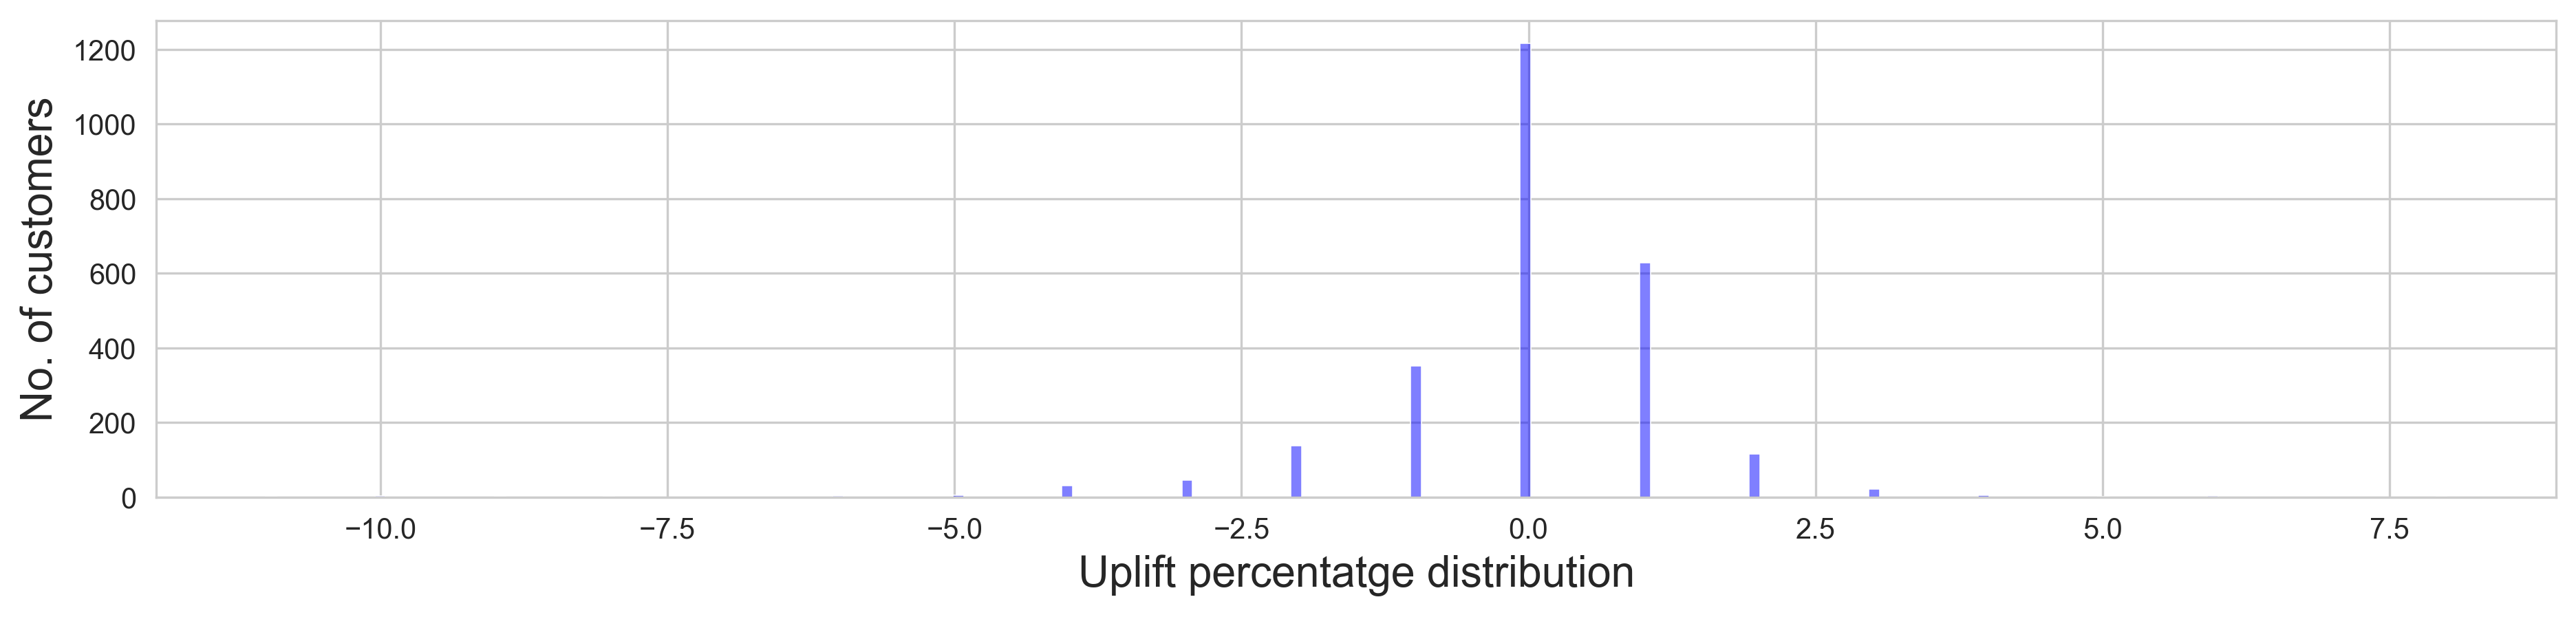

In [155]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.histplot(x='Uplift%',data=df_predicted[df_predicted['Uplift%'] > -50],color='blue',alpha=0.5,bins=200)
plt.xlabel('Uplift percentatge distribution',fontsize=15)
plt.ylabel('No. of customers',fontsize=15);

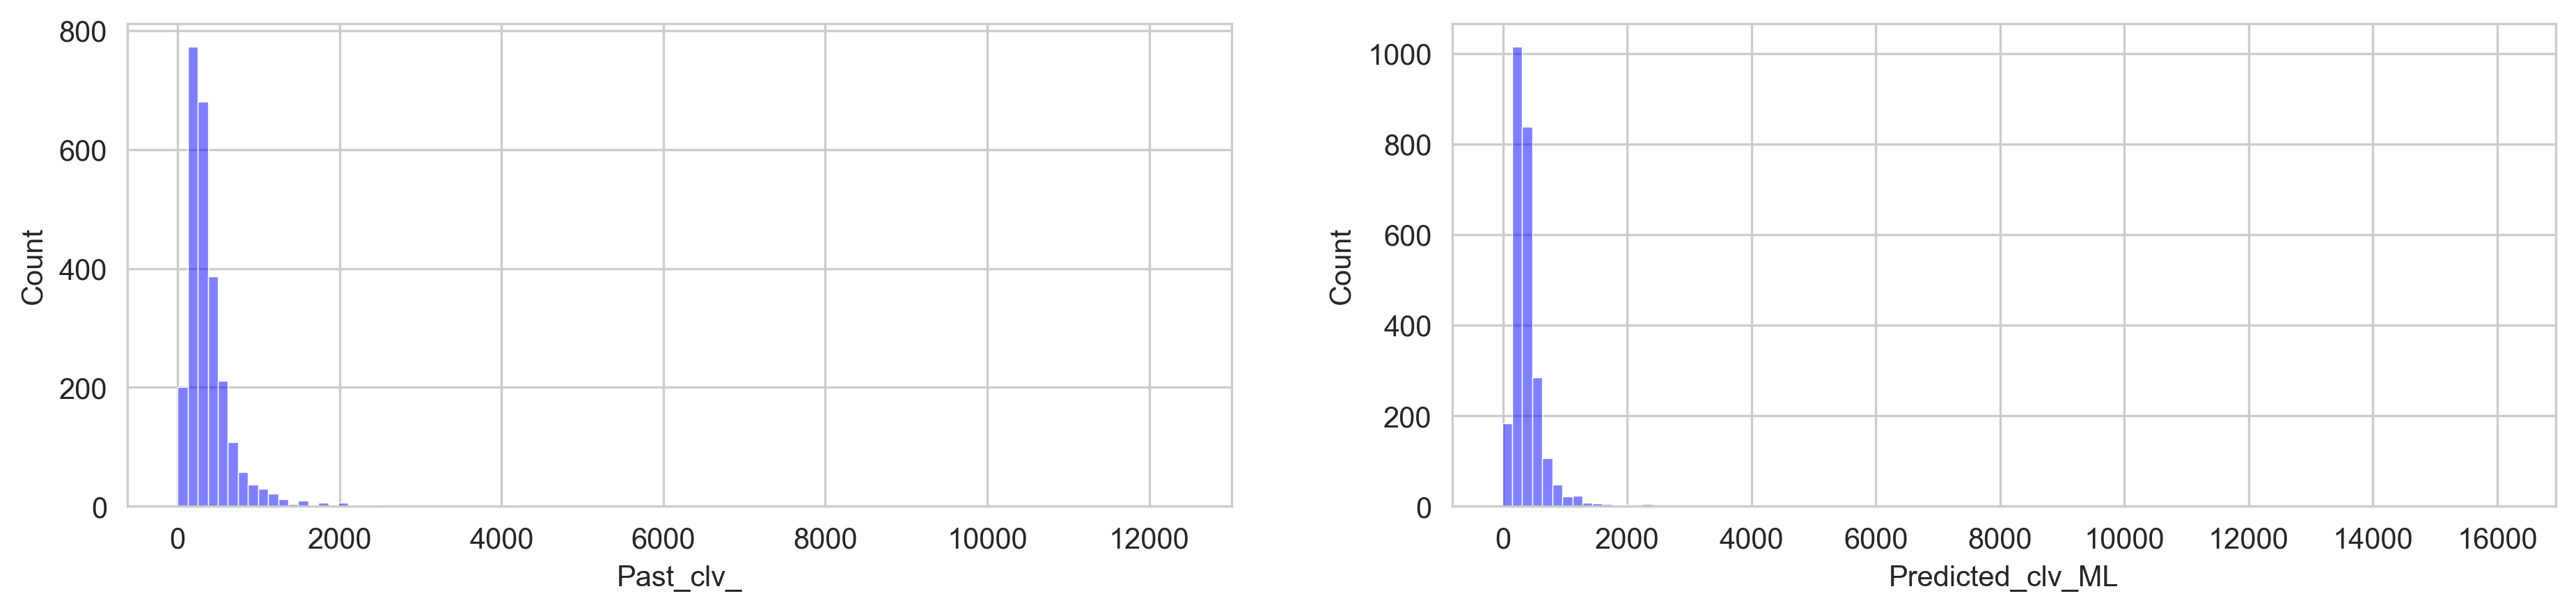

In [156]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,3),dpi=300)
ax1 = sns.histplot(ax=ax1,x='Past_clv_',data=df_predicted[df_predicted['Past_clv_'] < 20000],color='blue',alpha=0.5,bins=100)
ax2 = sns.histplot(ax=ax2,x='Predicted_clv_ML',data=df_predicted[df_predicted['Predicted_clv_ML'] < 20000],color='blue',alpha=0.5,bins=100)


In [157]:
import matplotlib.patches as mpatches

def graph(start,stop):
    ax,fig = plt.subplots(figsize=(15,5),dpi=300)
    
    ax = sns.barplot(y='Predicted_clv_ML',x='CustomerID',data=df_predicted,
                     order=df_predicted.iloc[start:stop,:].sort_values('Predicted_clv_ML',ascending = False).CustomerID,color='cyan',alpha=0.5)

    ax = sns.barplot(y='Past_clv_',x='CustomerID',data=df_predicted,
                     order=df_predicted.iloc[start:stop,:].sort_values('Predicted_clv_ML',ascending = False).CustomerID,color='magenta',alpha=0.5)
    
    plt.xticks(rotation=45,fontsize=8)

    top_bar = mpatches.Patch(color='cyan', label='Predicted_clv_ML',alpha=0.5)
    bottom_bar = mpatches.Patch(color='magenta', label='Past_clv_',alpha=0.5)
    plt.legend(handles=[top_bar, bottom_bar])

    plt.ylabel(f'Predicted customer lifetime value',fontsize=15)
    plt.xlabel(f'Customers ID for the {(stop-start)/100}% of predicted customers',fontsize=15);


In [158]:
print(f'Total number of customers: {len(df_predicted)}')

Total number of customers: 2569


### Customers

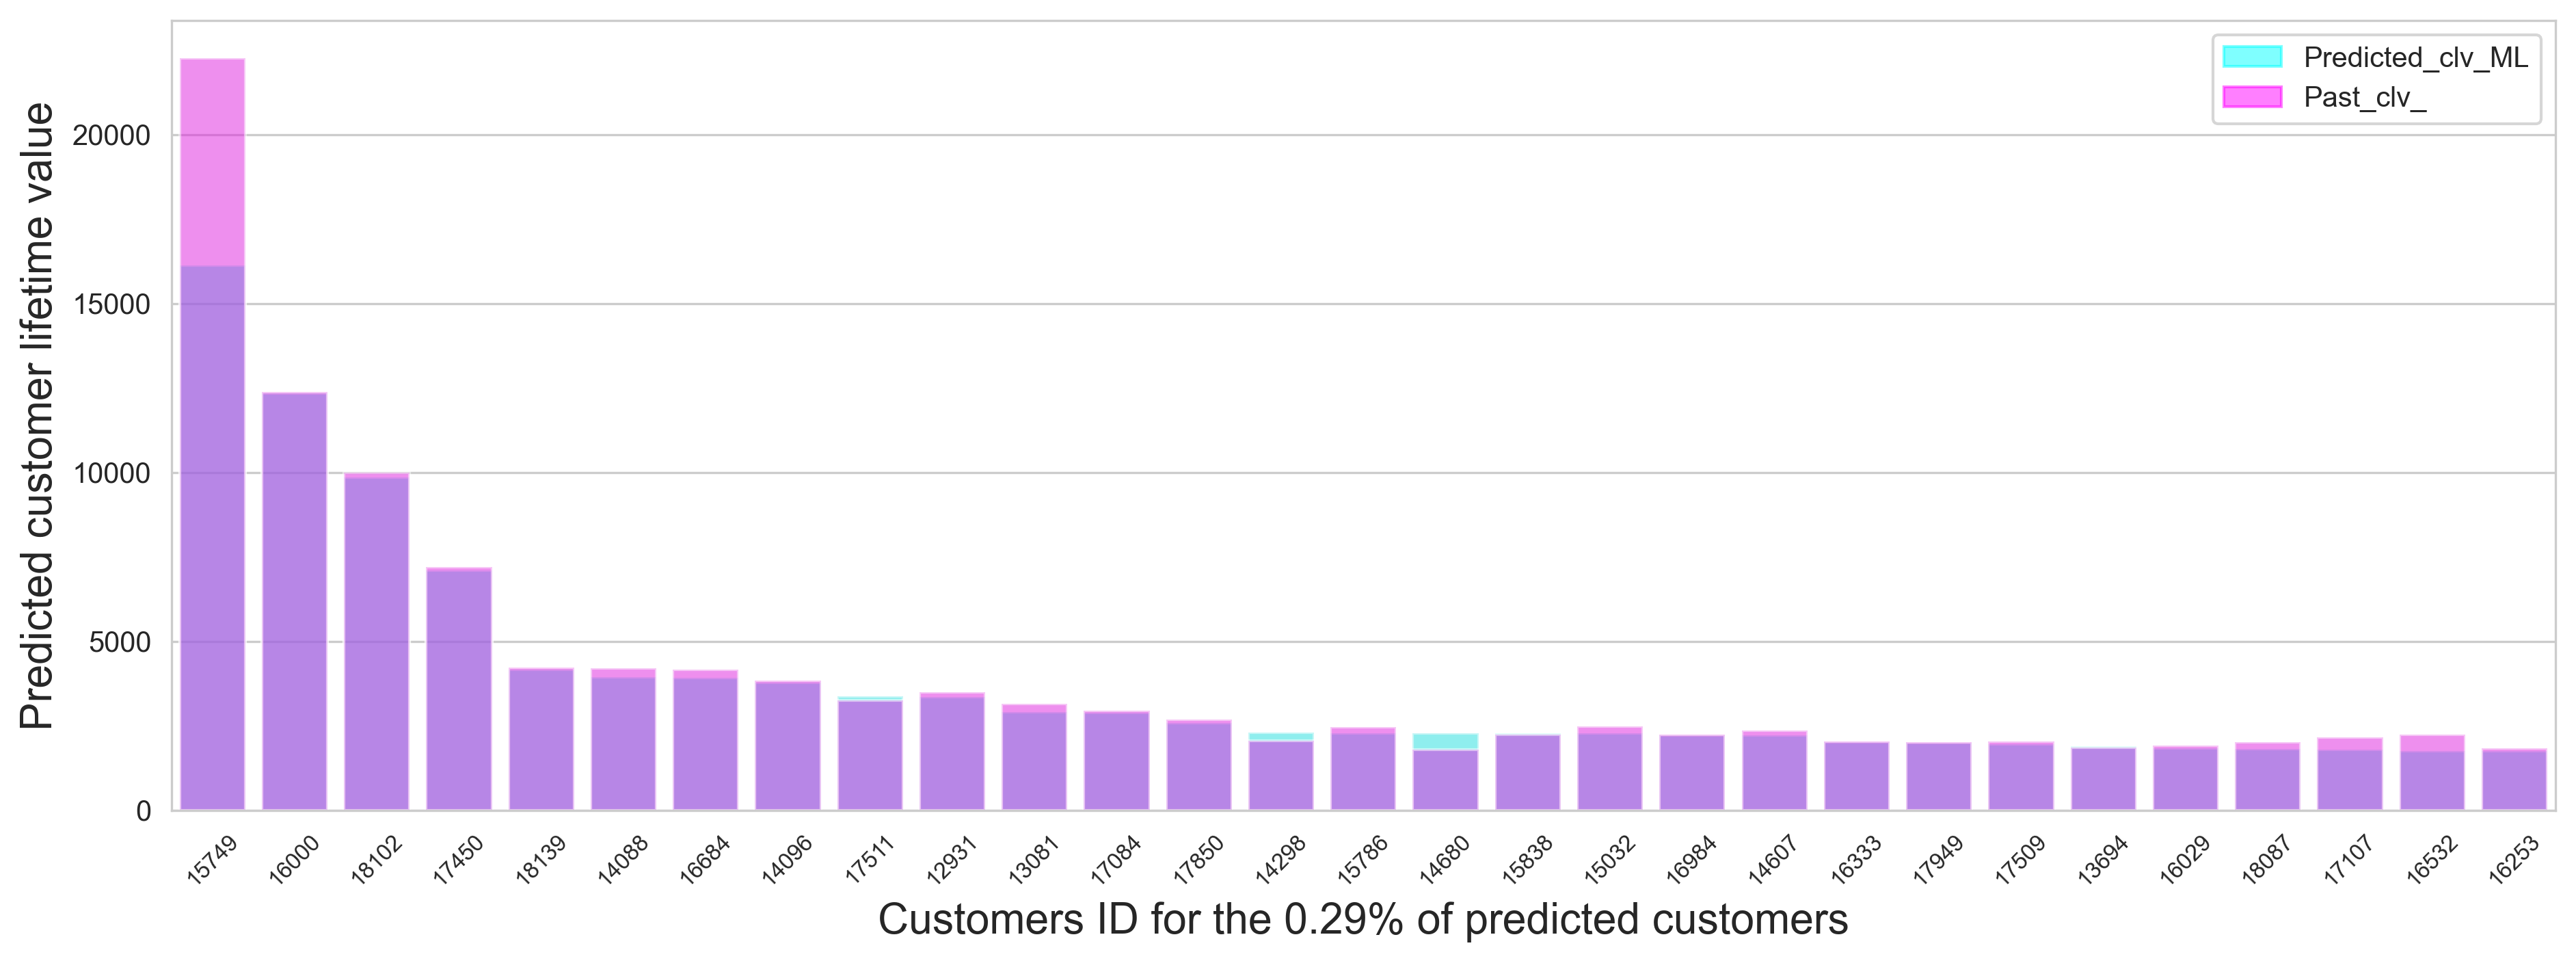

In [159]:
graph(1,30)

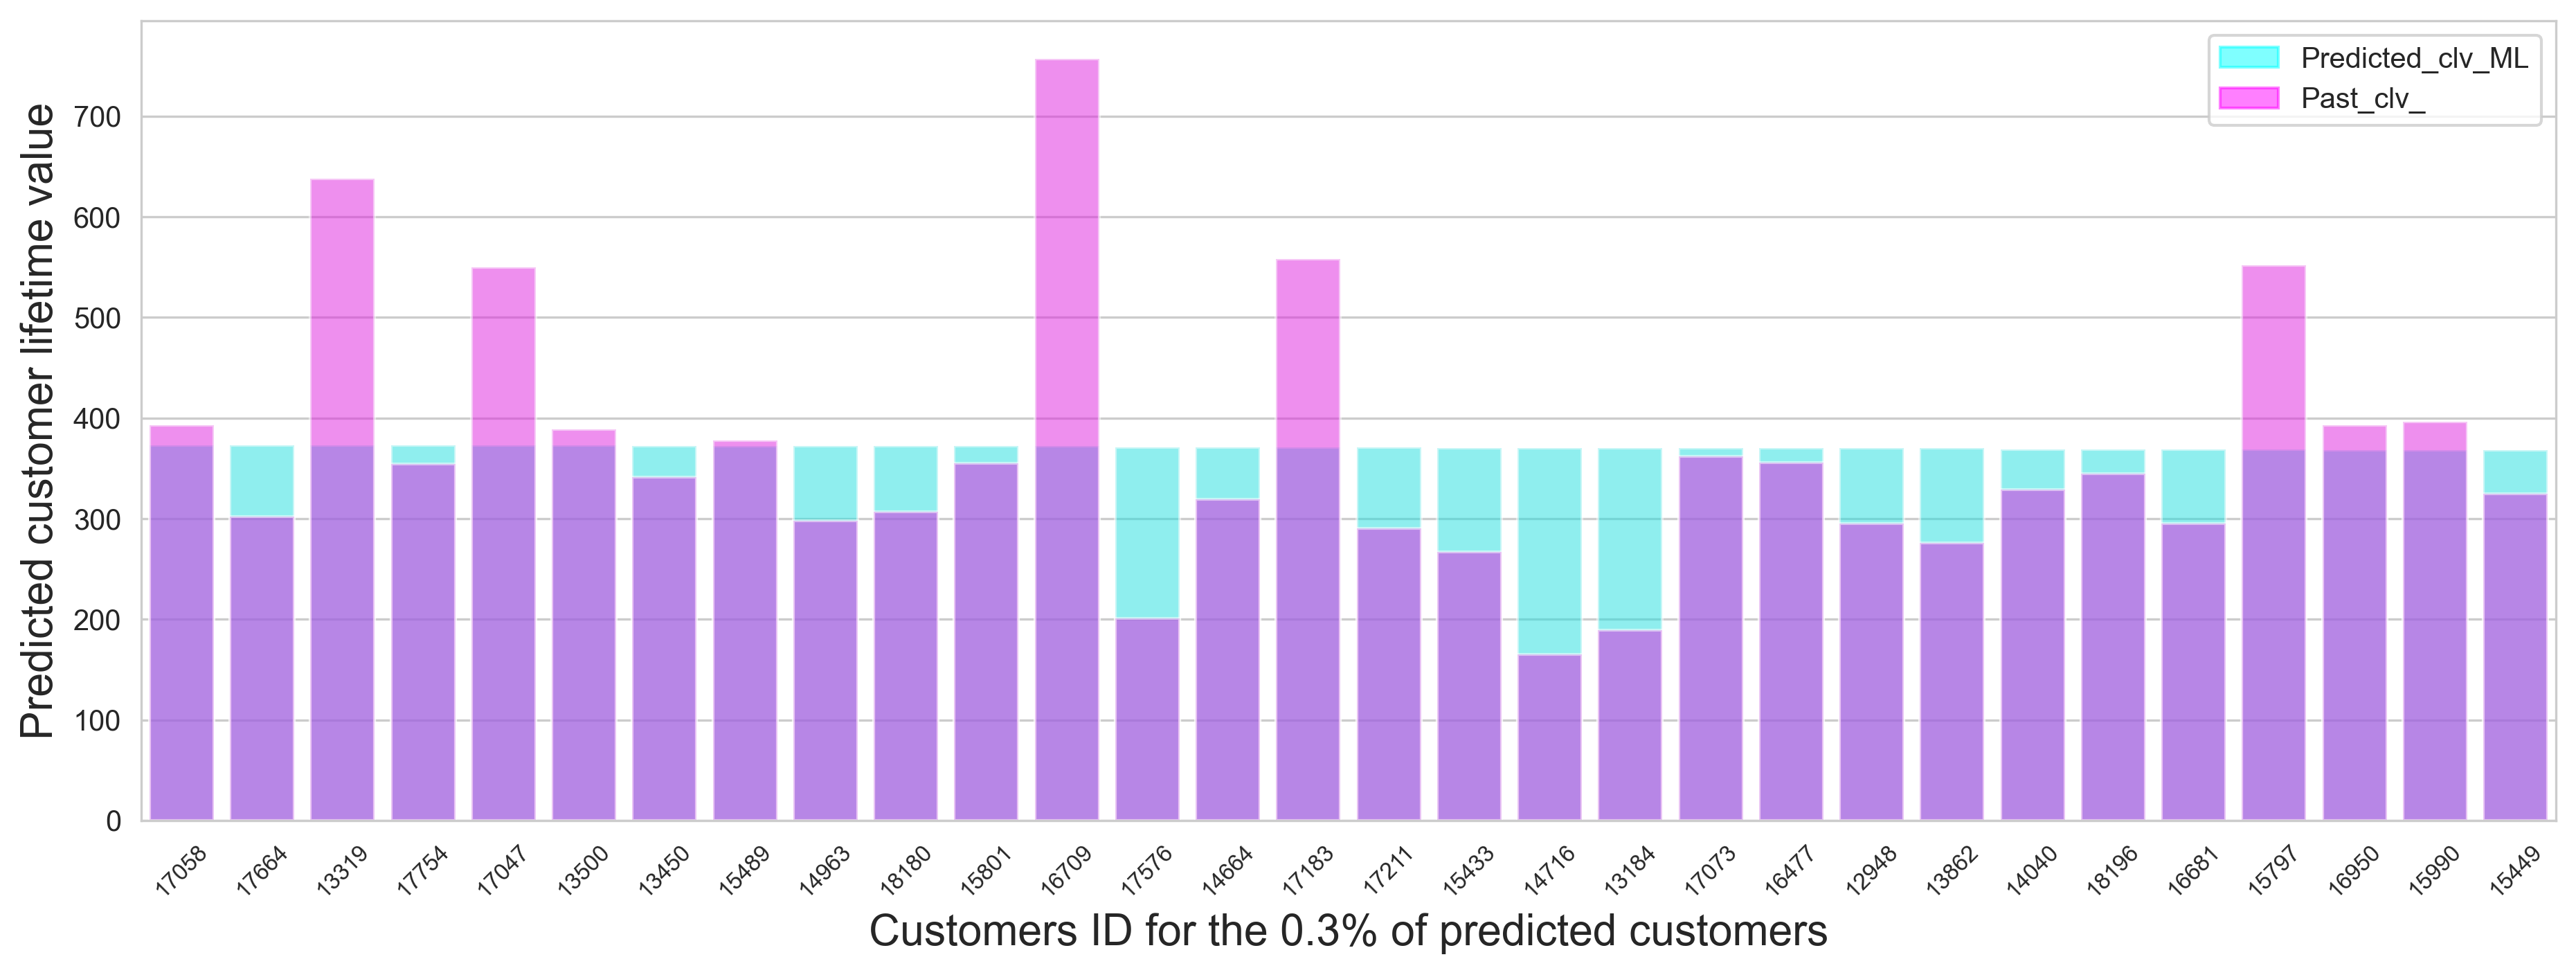

In [160]:
graph(1000,1030)

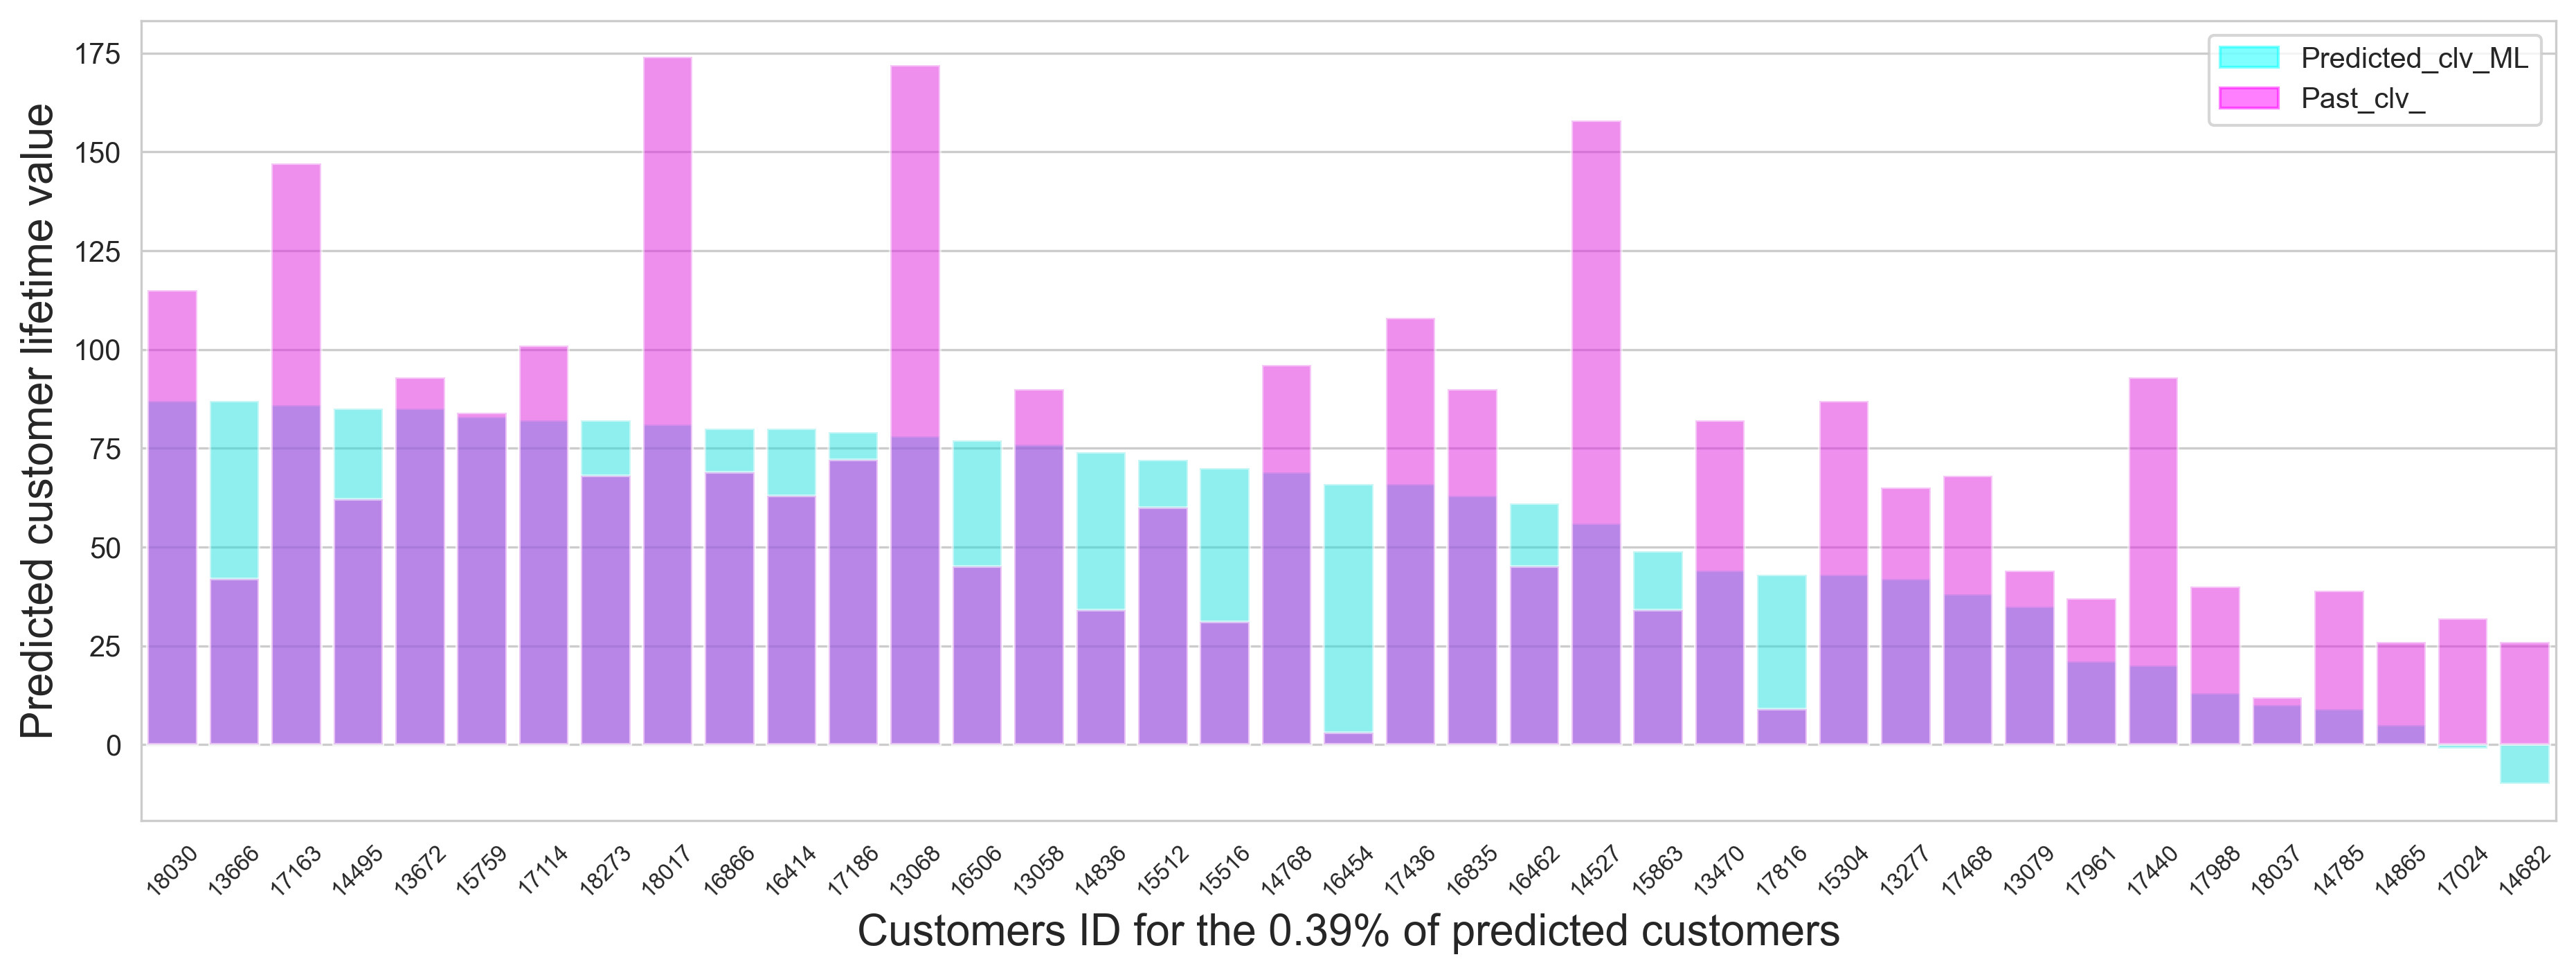

In [161]:
graph(2530,2569)

In [162]:
one = 15311
two = 16746
three = 17574

df_predicted[(df_predicted['CustomerID'] == one)|(df_predicted['CustomerID']== two)|(df_predicted['CustomerID']== three)]

,CustomerID,Past_frequency,Past_lifetime,Past_clv_segment,Predicted_clv_segment,Past_clv_,Predicted_clv_ML,Uplift%
73,15311,91,373,1.0,1,675.0,1090.0,4.0
615,16746,18,358,1.0,1,394.0,450.0,1.0


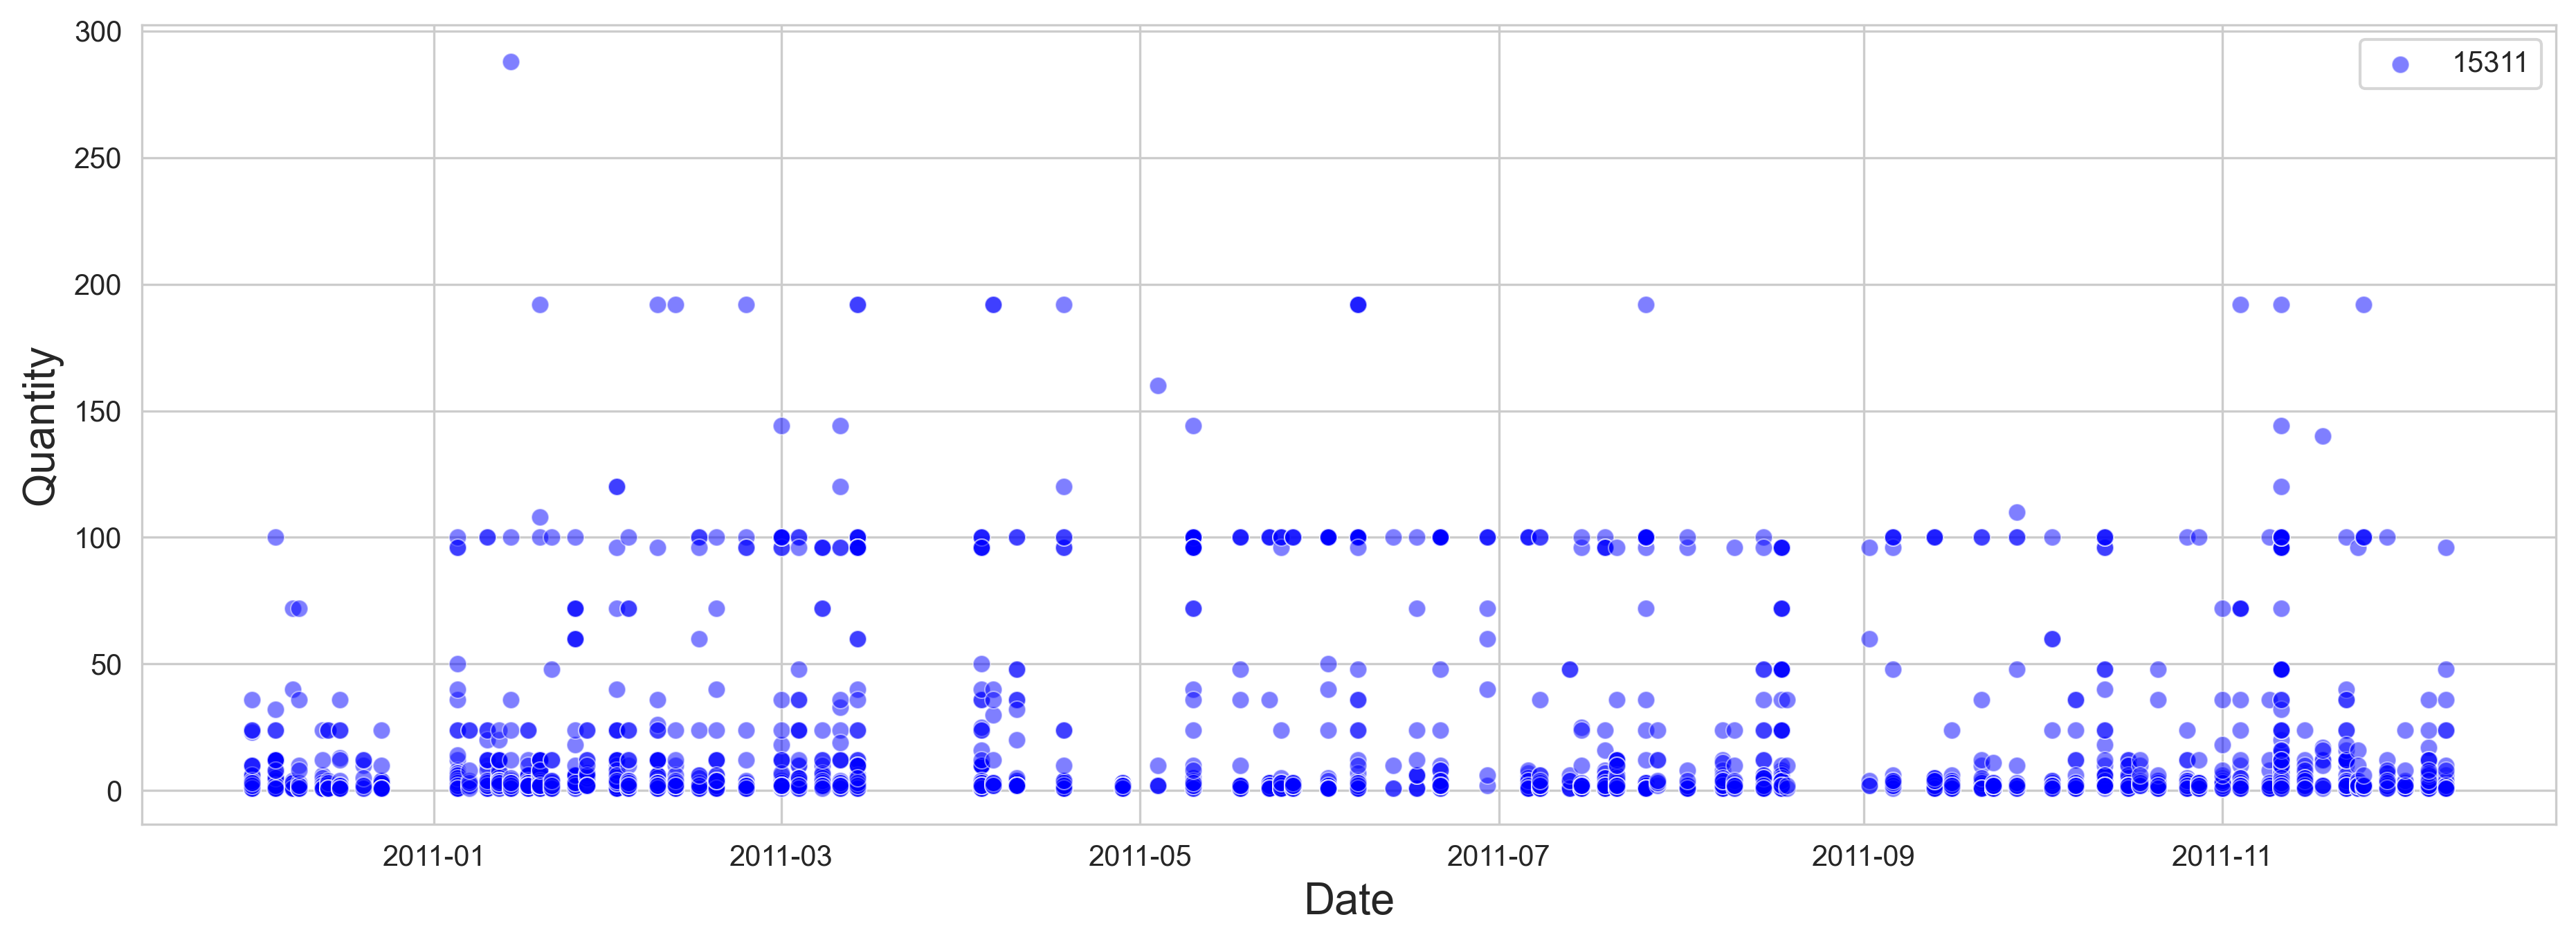

In [163]:
customer_1 = df_modified[df_modified['CustomerID']== one][['Quantity','Date','CustomerID']]

ax,fig = plt.subplots(figsize=(15,5),dpi=300)
ax = sns.scatterplot(y='Quantity',x='Date',data=customer_1,color='blue',alpha=0.5)

plt.legend([one,two])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15);


In [164]:
c = df_predicted[(df_predicted['CustomerID'] == 15311)]
c

,CustomerID,Past_frequency,Past_lifetime,Past_clv_segment,Predicted_clv_segment,Past_clv_,Predicted_clv_ML,Uplift%
73,15311,91,373,1.0,1,675.0,1090.0,4.0


# Calculate monthly retention for the last year

In [165]:
df_retention = df_modified.copy()

df_retention['Monetary'] = df_retention['UnitPrice'] * df_retention['Quantity']
df_retention = df_retention[df_retention['Date'] > '31-12-2010']
df_retention['Month'] = df_retention['Date'].dt.month
df_retention = df_retention.drop('Date',axis=1)

df_retention = df_retention.groupby(['CustomerID','Month'])['Monetary'].sum().reset_index()

df_retention = pd.crosstab(df_retention['CustomerID'], df_retention['Month']).reset_index()
months = df_retention.columns[1:]

retention_array = []

for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_month = months[i-1]
    retention_data['Month'] = selected_month
    retention_data['TotalCustomerCount'] = df_retention[selected_month].sum()
    retention_data['RetainedCustomerCount'] = df_retention[(df_retention[selected_month] > 0) & (df_retention[prev_month] > 0)][selected_month].sum()
    retention_array.append(retention_data)

df_retention = pd.DataFrame(retention_array)
df_retention['% RetentionRate'] = df_retention['RetainedCustomerCount'] / df_retention['TotalCustomerCount']
df_retention['% RetentionRate'] = df_retention['% RetentionRate'].apply(lambda x: x * 100)
df_retention['% RetentionRate'] = round(df_retention['% RetentionRate'],2)

#df_retention


Parsing '31-12-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.


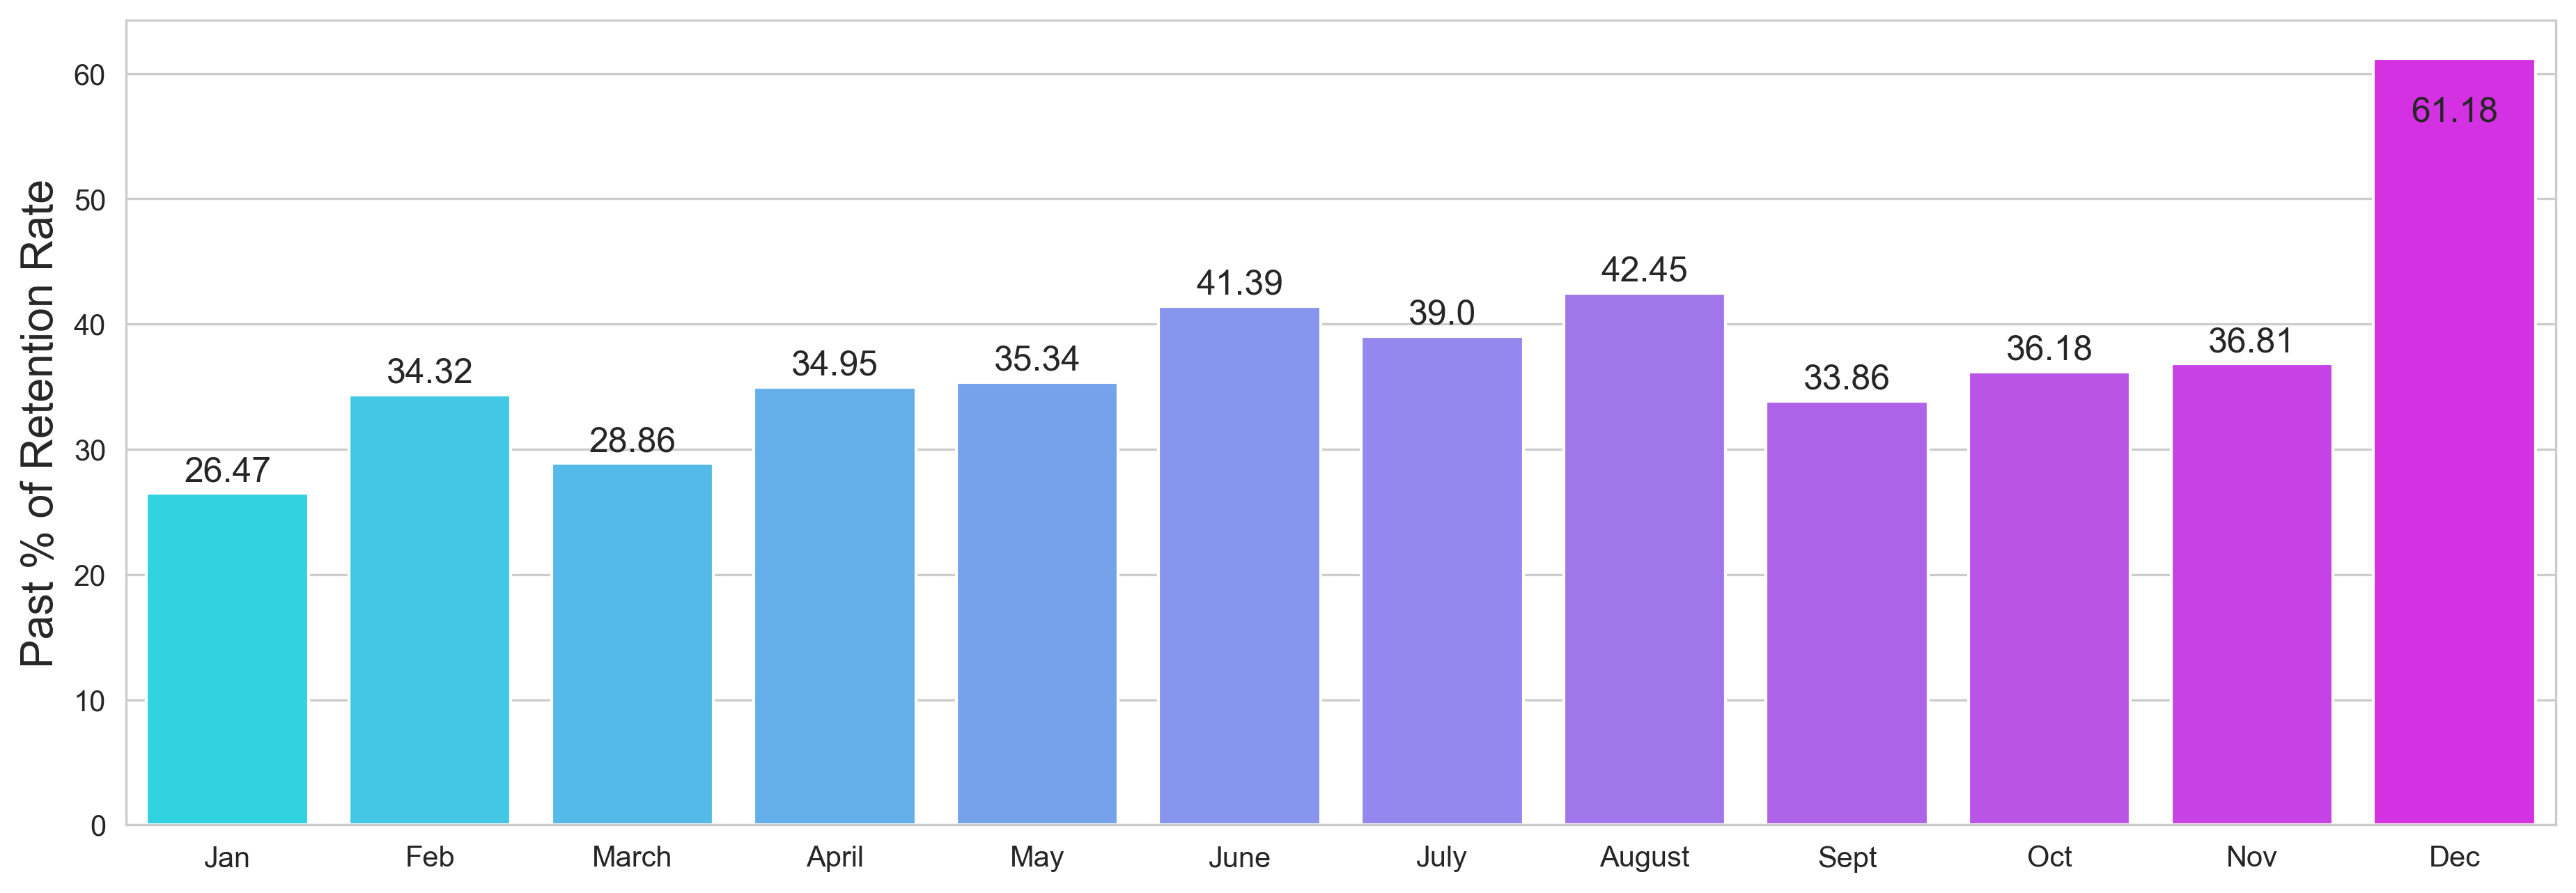

In [166]:
Months = ['Jan','Feb','March','April','May','June','July','August','Sept','Oct','Nov','Dec']
ax,fig = plt.subplots(figsize=(15,5),dpi=300)
ax = sns.barplot(x='Month',y='% RetentionRate',data=df_retention,palette='cool')
plt.ylabel('Past % of Retention Rate',fontsize=15)
plt.xlabel('')
ax.set_xticklabels(Months)

max_height=0
for x in ax.patches:
    h = x.get_height()
    max_height = h if h > max_height else max_height
    
for x in ax.patches:
    if x.get_height() < max_height:
        ax.annotate(x.get_height(),(x.get_x()+0.4,x.get_height()+1),ha='center',fontsize=12)
    else:
        ax.annotate(x.get_height(),(x.get_x()+0.4,x.get_height()-5),ha='center',fontsize=12);